## Capítulo 3 - Detalhes da regressão logística e exploração de características

### Objetivos do aprendizado

Ao fim deste capítulo, conseguirá

=> Criar list comprehensions em Python;

=> Descrever como funciona a regressão logística;

=> Formular as versões sigmóide e logit da regressão logística;

=> Utilizar a seleção univariada para encontrar características importantes;

=> Personalizar plotagens com a API Matplotlib;

=> Definir o limite de decisão linear de uma regressão logística;

Este capítulo apresentará os aspectos básicos da regressão logística e vários outros métodos para verificarmos o relacionamento entre as características e a variável de resposta.

### Introdução

Neste capítulo, começaremos a desenvolver técnicas para a avaliação individual de cada característica. Isso nos permitirá percorrer rapidamente todas as características para ver quais podem ser úteis na modelagem preditiva. Para as características mais promissoras, veremos como criar resumos visuais que sirvam como ferramentas de comunicação úteis.

Em seguida, iniciaremos nosso exame detalhado da regressão logística. Aprenderemos por que ela é considerada um modelo linear, mesmo quando as informações envolvem funções não lineares. Como consequência importante dessa linearidade, veremos por que o limite de decisão pode dificultar a classificação precisa dos dados. Conforme avançarmos, aprenderemos como escrever funções em Python

### Examinando os relacionamentos entre as características e a reposta

Para fazermos previsões precisas da variável de resposta, boas características são necessárias. Precisamos de características que estejam de alguma forma claramente vinculadas à variável de resposta. Até agora, examinamos os relacionamento entre algumas características e a variável de resposta, calculando o resultado da operação 'groupby/mean' da variável, ou testando modelos diretamente que é outra maneira de fazer esse tipo de exploração.

Uma maneira popular de examinar rapidamente como todas as características estão relacionadas à variável de resposta, e como elas se relacionam umas com as outras, é usando uma 'plotagem de correlação'. 

Para criarmos uma plotagem de correlação, as entradas necessárias devem incluir todas as características que serão exploradas, além da variável de reposta.

In [1]:
import numpy             as np  # cálculo numérico
import pandas            as pd  # preparação dos dados
import matplotlib.pyplot as plt # pacote de plotagem

# A pŕoxima linha ajuda a renderizar plotagens
%matplotlib inline

import matplotlib        as mpl # Adiciona funcionalidade de plotagem
import seaborn           as sns # Um pacote de plotagem interessante

In [2]:
mpl.rcParams['figure.dpi'] = 400 # Figuras em alta resolução
df = pd.read_csv('../Data/Chapter_1_cleaned_data.csv')

O Pacote 'Seaborn', tem muitos recursos de plotagens convenientes baseados no 'Matplotlib'

Agora faremos uma lista de todas as colunas do DataFrame e examinaremos as primeiras e as últimas cinco:

In [3]:
features_response = df.columns.tolist()

In [4]:
features_response[:5] # as primeiras 5 linhas

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']

In [5]:
features_response[-5:] # as 5 últimas linhas

['graduate school', 'high school', 'none', 'others', 'university']

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,none,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,1,university,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,1000,0,2000,1,university,0,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,1000,1000,5000,0,university,0,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,1100,1069,1000,0,university,0,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,9000,689,679,0,university,0,0,0,0,1


Será usado apenas a características 'EDUCATION'. Para concluir, não faz sentido usar 'ID' como característica, porque se trata somente de um identificador de conta exclusivo que não tem ligação com a variável de resposta. Criaremos outra lista de nomes de colunas que não sejam característica ou resposta.

In [7]:
# Será excluído os itens abaixo da análise
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4','PAY_5', 'PAY_6', 
                   'EDUCATION_CAT', 'graduate school', 'high school', 
                  'none', 'others', 'university']

list comprehension => Permite a criação de listas que seriam distribuídas em várias linhas de um loop real.

In [8]:
# Exemplo de uma list comprehension
example_list_comp = [item for item in range(5)]
example_list_comp

[0, 1, 2, 3, 4]

Também podemos usar cláusulas tradicionais para tornar as 'list comprehensions' flexíveis. Por exemplo, podemos usá-las para reatribuir a variável 'features_response' com uma lista contendo tudo que não esteja na lista strings que queremos remover.

In [9]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

### Correlação de Pearson

Estamos prontos para criar nossa plotagem de correlação. Ela sempre se baseia em uma 'matriz de correlação', que devemos calcular primeiro. O pandas facilita isso. Só temos de selecionar nossas colunas de características e valores de resposta usando a lista que acabamos de criar e chamar o método '.corr()'nelas. Enquanto fazemos o cálculo, observe que o tipo de correlação que está disponível para nós no pandas é a 'correlação linear', também conhecida como 'correlação de Pearson'.

A correlação de Pearson é usada para medir a força e a direção (isto é, positiva ou negativa) do relacionamento linear entre duas variáveis:

In [10]:
corr = df[features_response].corr()
corr.iloc[0:5, 0:5]

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1
LIMIT_BAL,1.000000,-0.232688,-0.111873,0.149157,-0.273396
EDUCATION,-0.232688,1.000000,-0.137097,0.179035,0.112653
MARRIAGE,-0.111873,-0.137097,1.000000,-0.412828,0.019759
AGE,0.149157,0.179035,-0.412828,1.000000,-0.044277
PAY_1,-0.273396,0.112653,0.019759,-0.044277,1.000000


<AxesSubplot:>

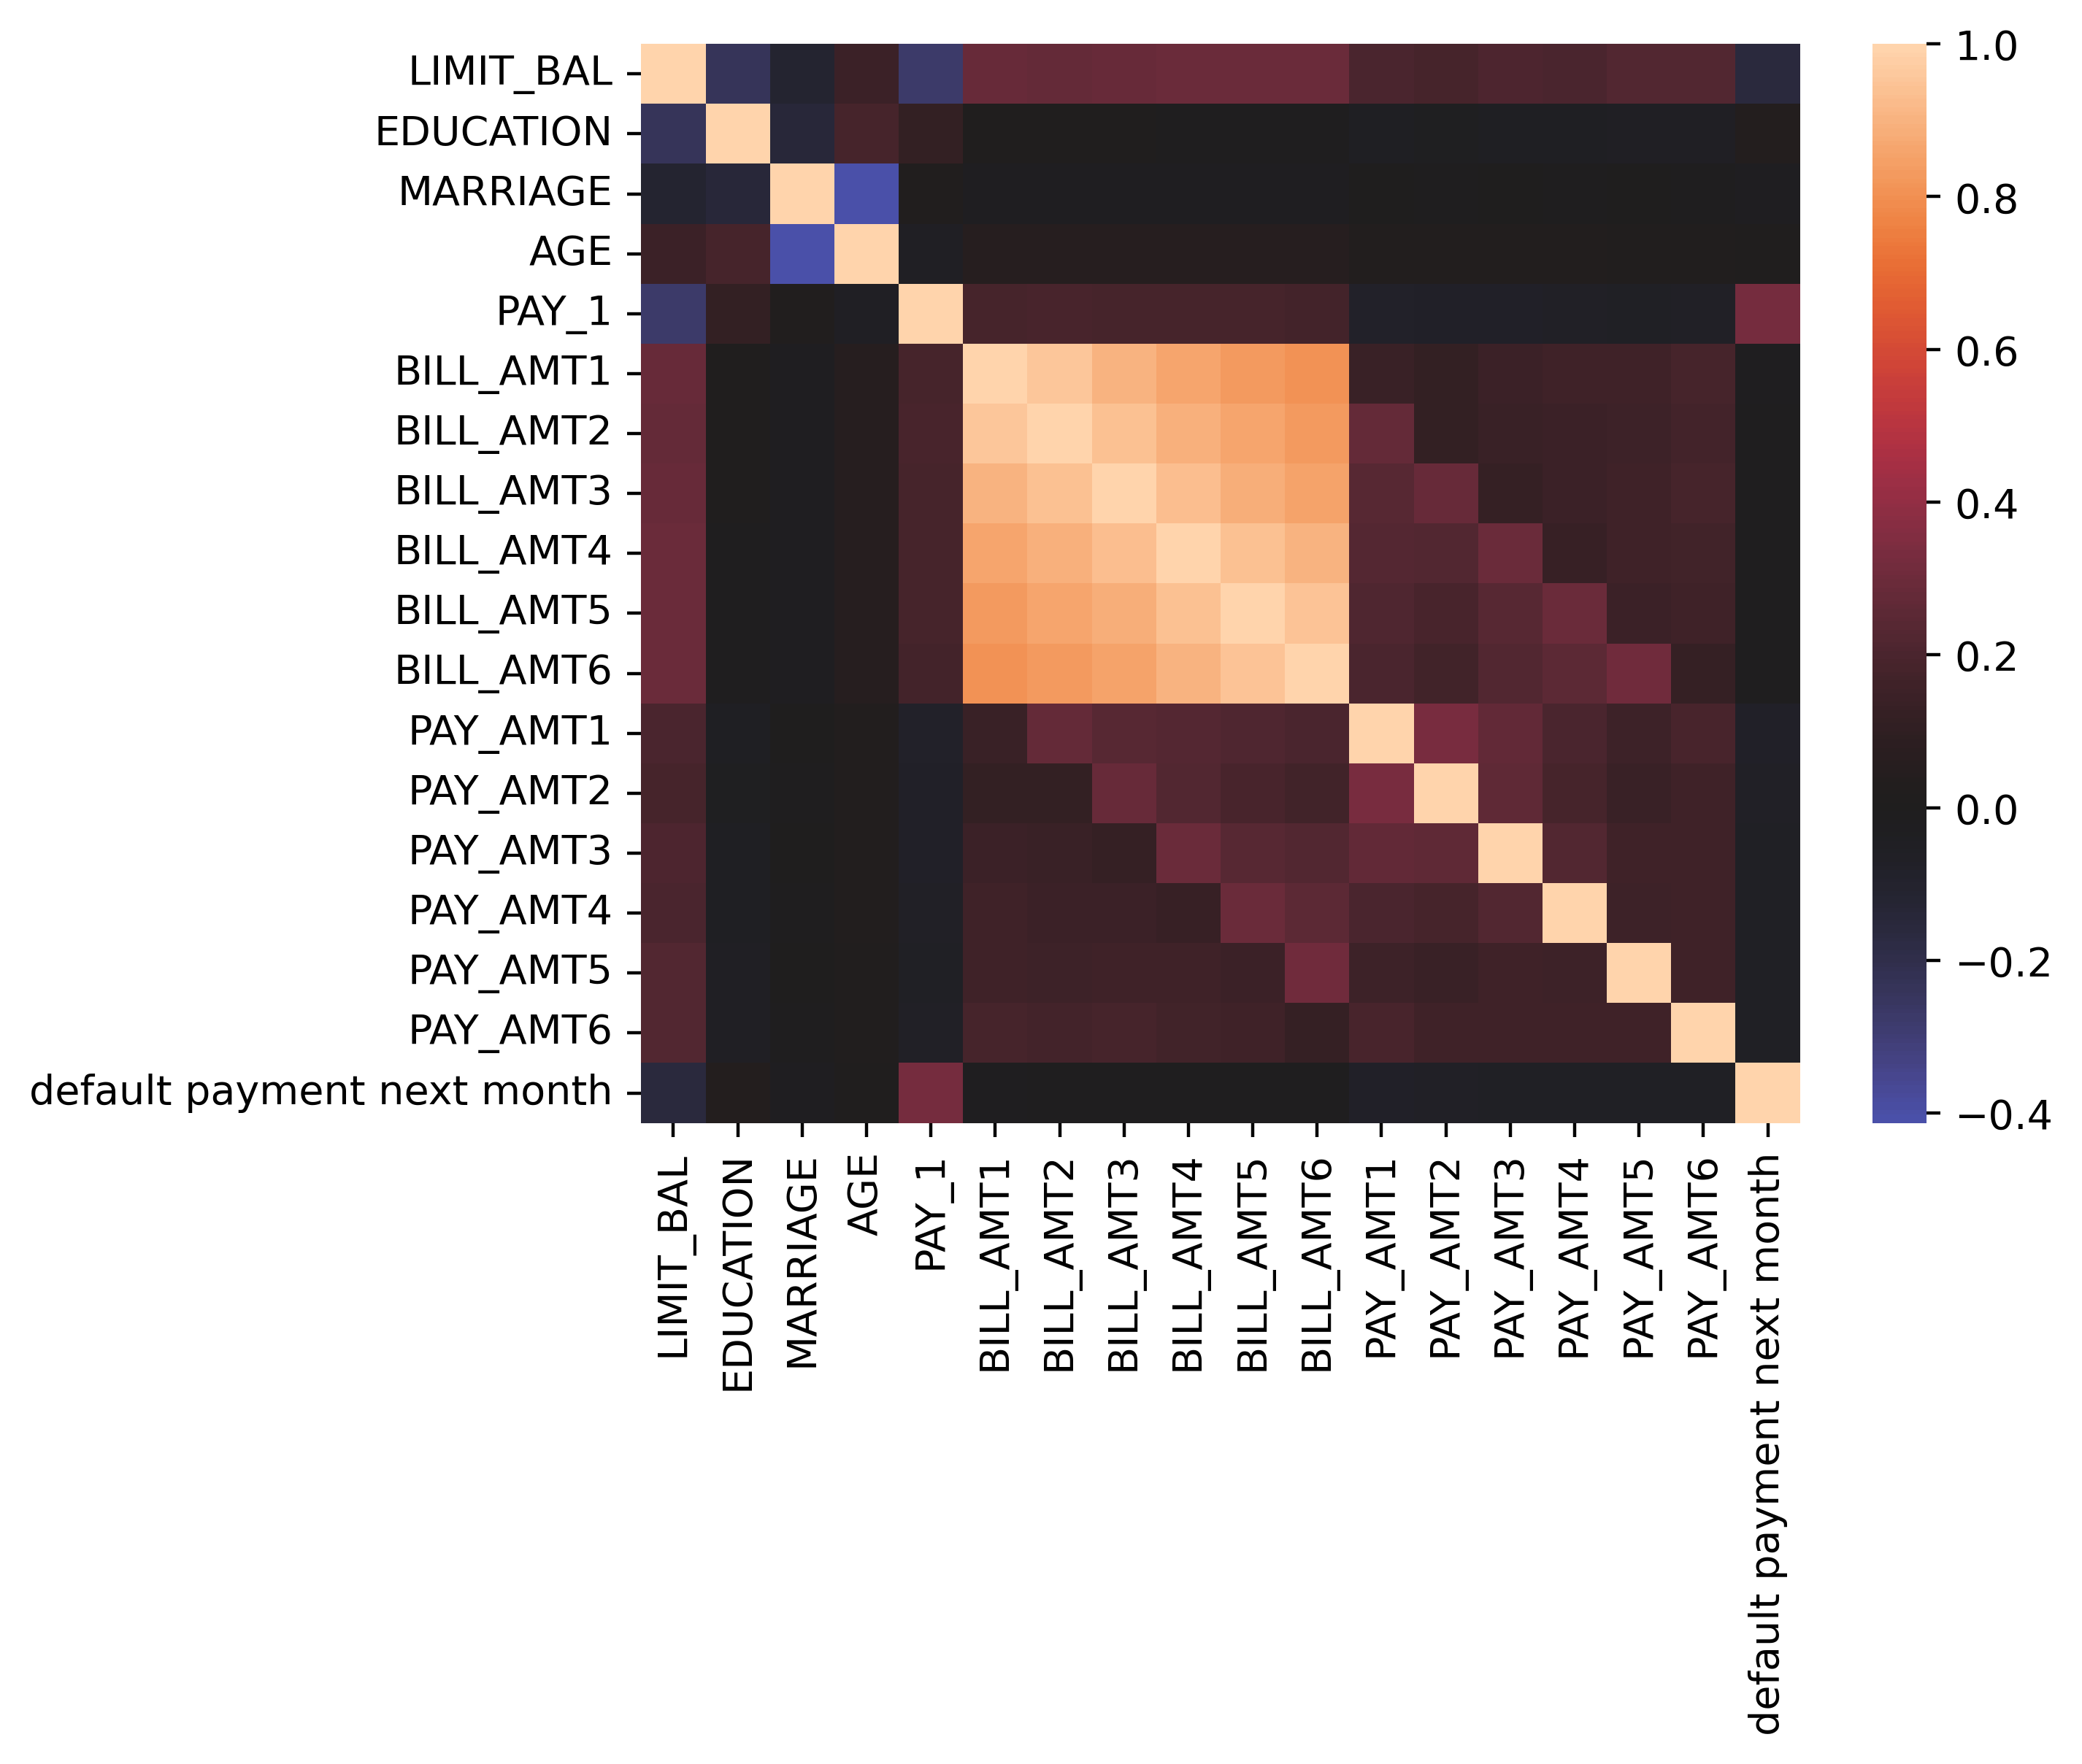

In [11]:
# Plotagem com o Seaborn, para motrar as correlações
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    center=0
)

### Exercício 11: Teste F e seleção de características univariada
    
Neste exercício, será usado o teste F para examinar a relação entre as características e a resposta.Será investigado esse método como parte do que é chamado de 'seleção de características univariada': a prática de testar características uma a uma em relação á variável de resposta para ver quais têm poder preditivo. Execute as etapas a seguir para fazer o exercício: 

1) A primeira etapa para a execução do teste 'F A NOVA' é separar as características e a resposta como arrays NumPy usando a lista que criamos e a indexação de inteiros do pandas:

In [12]:
# Dimensão dos arrays de características e da resposta
X = df[features_response].iloc[:,:-1].values
y = df[features_response].iloc[:,-1].values

In [13]:
print(X.shape, y.shape)

(26664, 17) (26664,)


Há 17 características, e os arrays tanto de características quanto da resposta têm o mesmo número de amostras como esperado.

2) Importe a função 'f_classif' e forneça as características e a resposta:

In [14]:
from sklearn.feature_selection import f_classif
[f_stat, f_p_value] = f_classif(X, y)

Duas saídas são obtidas de 'f_classif': a 'estatística F' e o 'valor-p', para a comparação de cada característica com a variável de resposta. Será criado um novo DataFrame contendo os nomes das características e essas saídas para facilitar nossa inspeção.
    
Uma maneira de especificar um novo DataFrame é usando um 'dicionário', com pares 'chave:valor' de nomes de colunas e dos dados que ficarão contidos em cada uma delas. Mostraremos o DataFrame classificado (de forma ascendente) pelo valor-p.

3) Use este código para criar um DataFrame com nomes de características, com a estatística F e com os valores-p e exiba-o classificado pelo valor-p:

In [15]:
f_test_df = pd.DataFrame({'Feature':features_response[:-1],
                          'F statistic':f_stat,
                          'p value':f_p_value})

In [16]:
f_test_df.sort_values('p value')

,Feature,F statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


Observe que, para cada diminuição no valor-p, há um aumento na estatística F, logo, as informações dessas colunas são basicamente as mesmas em termos de classificação de características. 

As conclusões a que podemos chegar pelo DataFrame da estatística F e dos valores-p são semelhantes ao que observamos na plotagem de correlação: PAY_1 e LIMIT_BAL parecem ser as características mais úteis. Elas têm valores-p menores, o que indica que os valores da média dessas características entre a classe positiva e negativa são significativamente diferentes, e ajudarão a prever a que classe uma amostra pertence.
    
No scikit-learn, um dos usos para avaliações como o teste F é na execução da seleção de características univariada. Isso pode ser benéfico se tiver um número muito grande de características, várias talvez totalmente inúteis, e quiser uma maneira rápida de obter uma "lista curta" com as mais úteis. Por exemplo, se quiséssemos recuperar apenas 20% das características com maior estatística F, poderíamos fazer isso facilmente com a classe 'SelectPercentile'. É bom ressaltar também que há uma classe semelhante para a seleção das 'k', principais características (em que k é qualquer número que especificarmos), chamada 'selectKBest'. Aqui demonstraremos como selecionar as 20% melhores.

4) Para selecionar as características consideradas pelo teste F como as 20% melhores, primeiro importe a classe 'SelectPercentile':

In [17]:
from sklearn.feature_selection import SelectPercentile

5) Instancie um objeto dessa classe, indicando que queremos, usar o mesmo critério de seleção de características, o teste F ANOVA, que consideramos até agora neste exercício, e que, entre as características, queremos as 20% melhores:

In [18]:
selector = SelectPercentile(f_classif, percentile=20)

6) Use o método '.fit' para ajustar o objeto ás características e aos dados da resposta, semelhante a como um modelo seria ajustado.

In [19]:
selector.fit(X, y)

SelectPercentile(percentile=20)

Há várias maneiras de acessar as características selecionadas diretamente, o que pode aprender da documentação do scikit-learn (examinando o método '.tranform', ou o emprego de '.fit_transform' na etapa do ajuste). No entanto, esses métodos retornarão arrays NumPy, que não informam os nomes das características que foram selecionadas, somente os valores. Para resolver isso, pode usar o método '.get_support' do objeto seletor de características, que lhe informará os índices de colunas selecionados no array de características.

7) Capture os índices das características selecionadas em um array chamado 'best_feature_ix':

In [20]:
best_features_ix = selector.get_support()
best_features_ix

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

A saída deve ser um índice lógico que pode ser usado com um array de nomes de características, assim como valores, supondo que estejam na mesma ordem do array de características fornecido para 'SelectPercentile':

8) Os nomes das características podem ser obtidos com o uso de todos os elementos exceto o último (nome da variável de resposta) de nossa lista 'features_response' pela indexação com ': -1'.
    

In [21]:
features = features_response[:-1]
features

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

9) Use o array de índices que criamos na 'ETAPA 7' com uma list comprehension e a lista 'features' para encontrar os nomes das características selecionadas, como descrito a seguir:

In [22]:
best_features = [features[counter] for counter in range(len(features))
                if best_features_ix[counter]]

best_features

['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2']

Nesse código, a list comprehension percorreu is elementos do array features (len(features)) com o incremento de loop counter, usando o array booleano best_feature_ix, que representa as características selecionadas, na instrução if para verificar cada característica e capturar o nome das escolhidas.

### Pontos mais importantes do teste F: equivalência com o teste t para duas classes e cuidados
    
Quando é usado um teste f para examinar a diferença de média somente entre dois grupos, como fizemos aqui para o problema de classificação binária do estudo de caso, na verdade o teste se resume ao que é conhecido como 'teste t'. Um teste F é extensível a três ou mais grupos e, portanto, é útil para a classificação multiclasse. Um teste t compara a média apenas entre dois grupos de amostras para ver se a diferença é "estatisticamente significativa".

### Hipóteses e próximas etapas

De acordo com nossa exploração de características univariada, a característica, a característica de maior associação com a variável de resposta é 'PAY_1'.Isso faz sentido? O que significa PAY_1? É o status de pagamento da conta no mês mais recente. Como aprendemos na exploração de dados inicial, há alguns valores que indicam que a conta está em boa situação: -2 significa que ela não foi usada, -1 indica saldo totalmente quitado e 0 significa que pelo menos o pagamento mínimo foi feito.Por outro lado, valores inteiros positivos indicam atraso ao pagamento relativo a esse número de meses.As contas com pagamentos em atrasados no último mês podem ser consideradas inadimplentes. 

Isso significa basicamente que essa característica captura valores históricos da variável de resposta. Características como essa são muito importantes como um dos melhores preditores para qualquer problema de 'machine learning' que use dados históricos para a mesma coisa que estamos tentando prever (ou seja, a varáivel de resposta). Parece lógico: pessoas que já ficaram inadimplentes apresentam maior risco de inadimplir novamente.

E quanto a 'LIMIT_BAL', o limite de crédito das contas? Se considerarmos como limites de crédito são atribuídos, é provável que nosso cliente tenha avaliado o risco que um tomador de empréstimo pode apresentar ao decidir sobre o limite. Clientes que apresentam mais risco devem receber limites mais baixos para que o credor tenha menos problemas. Logo, podemos esperar uma maior probabilidade de inadimplência para contas com valores menores para "LIMIT_BAT".

As hipóstes e visualizações costumam ser uma parte importante da apresentação de resultados para o cliente, que pode estar interessado em saber como o modelo funciona, e não apenas no fato de que ele funciona.

### Exercício 12: Visualizando o relacionamento entre as características e a resposta
    
Neste exercício, será aumentado o conhecimento sobre as funções de plotagem do Matplotlib. Aprenderemos como personalizar os gráficos para responder melhor as perguntas específicas usando os dados. Ao fazer essas análises, criaremos visualizações significativas de como as características PAY_1 e LIMIT_BAL estão relacionadas com a variável de resposta, o que pode dar suporte às hipóteses que formulamos sobre elas. Isso será feito pela aquisição de um conhecimento maior da API Matplotlib

1) Calcule a linha de base da variável de resposta para a taxa de inadimplência de todo o dataset usando o método ".mean() do pandas".

In [23]:
overall_default_rate = df['default payment next month'].mean()
overall_default_rate

0.2217971797179718

###### Qual seria uma boa maneira de visualizar as taxas de inadimplência para diferentes valores da características PAY_1?

Lembre-se de que verificamos que essa característica é híbrida, sendo tanto categórica quanto numérica. Vamos plotá-la de uma forma que é típica de características categóricas, devido ao número relativamente pequeno de valores exclusivos. 

2) Use o código para criar uma agregação "groupby/mean":

In [24]:
group_by_pay_mean_y = df.groupby('PAY_1').agg({'default payment next month' : np.mean})
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


Com a verificação desses valores já podemos discernir a tendência. Passaremos direto à sua plotagem. Vamos executá-la por etapas e introduziremos alguns conceitos novos. Deve inserir todo o código das etapas 3 a 6 na mesma célula.

No Matplotlib, cada plotagem aparece em um objeto axes e dentro de uma janela figure. Criando objetos para axes e figures, pode acessar e alterar diretamente suas propriedades, inclusive os rótulos dos eixos, as tick marks, e outros elementos  dos eixos, ou as dimensões da figura.

3) Crie um objeto axes em uma variável também chamada axes usando o código a seguir:

axes = plt.axes()

4) Plote a taxa de inadimplência geral como uma linha horizontal vermelha.

O Matplotlib facilita essa operação; só precisa indicar a interceptação de y na linha com a função axhline. Observe que, em vez de chamar a função a partir de plt, estamos chamando-a como um método em objeto axes:
    
axes.axhline(overall_default_rate, color='red')

5) Use o método plot do DataFrame de dados agrupados que criamos. Especifique um marcador 'x' ao longo da plotagem da linha e a inexistência de uma instância de legend, que criaremos posteriormente; informe que o eixo pai da plotagem deve ser o objeto axes com o qual estamos trabalhando (caso contrário, o pandas removerá o objeto inexistente e criará um novo objeto axes):
    
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)    

6) Defina o rótulo do eixo y e crie uma instância  de legend (há muitas opções para controlarmos a aparência da legenda, mas uma maneira simples é fornecer uma lista de strings indicando os rótulos dos elementos gráficos na ordem em que foram adicionados a axes):

axes.set_ylabel('Proportion of credit defaults')
axes.legend(['Entire dataset', 'Groups of PAY_1'])

7) A execução de todo o código das Etapas 3 a 6 em uma única célula de resultar na plotagem a seguir:

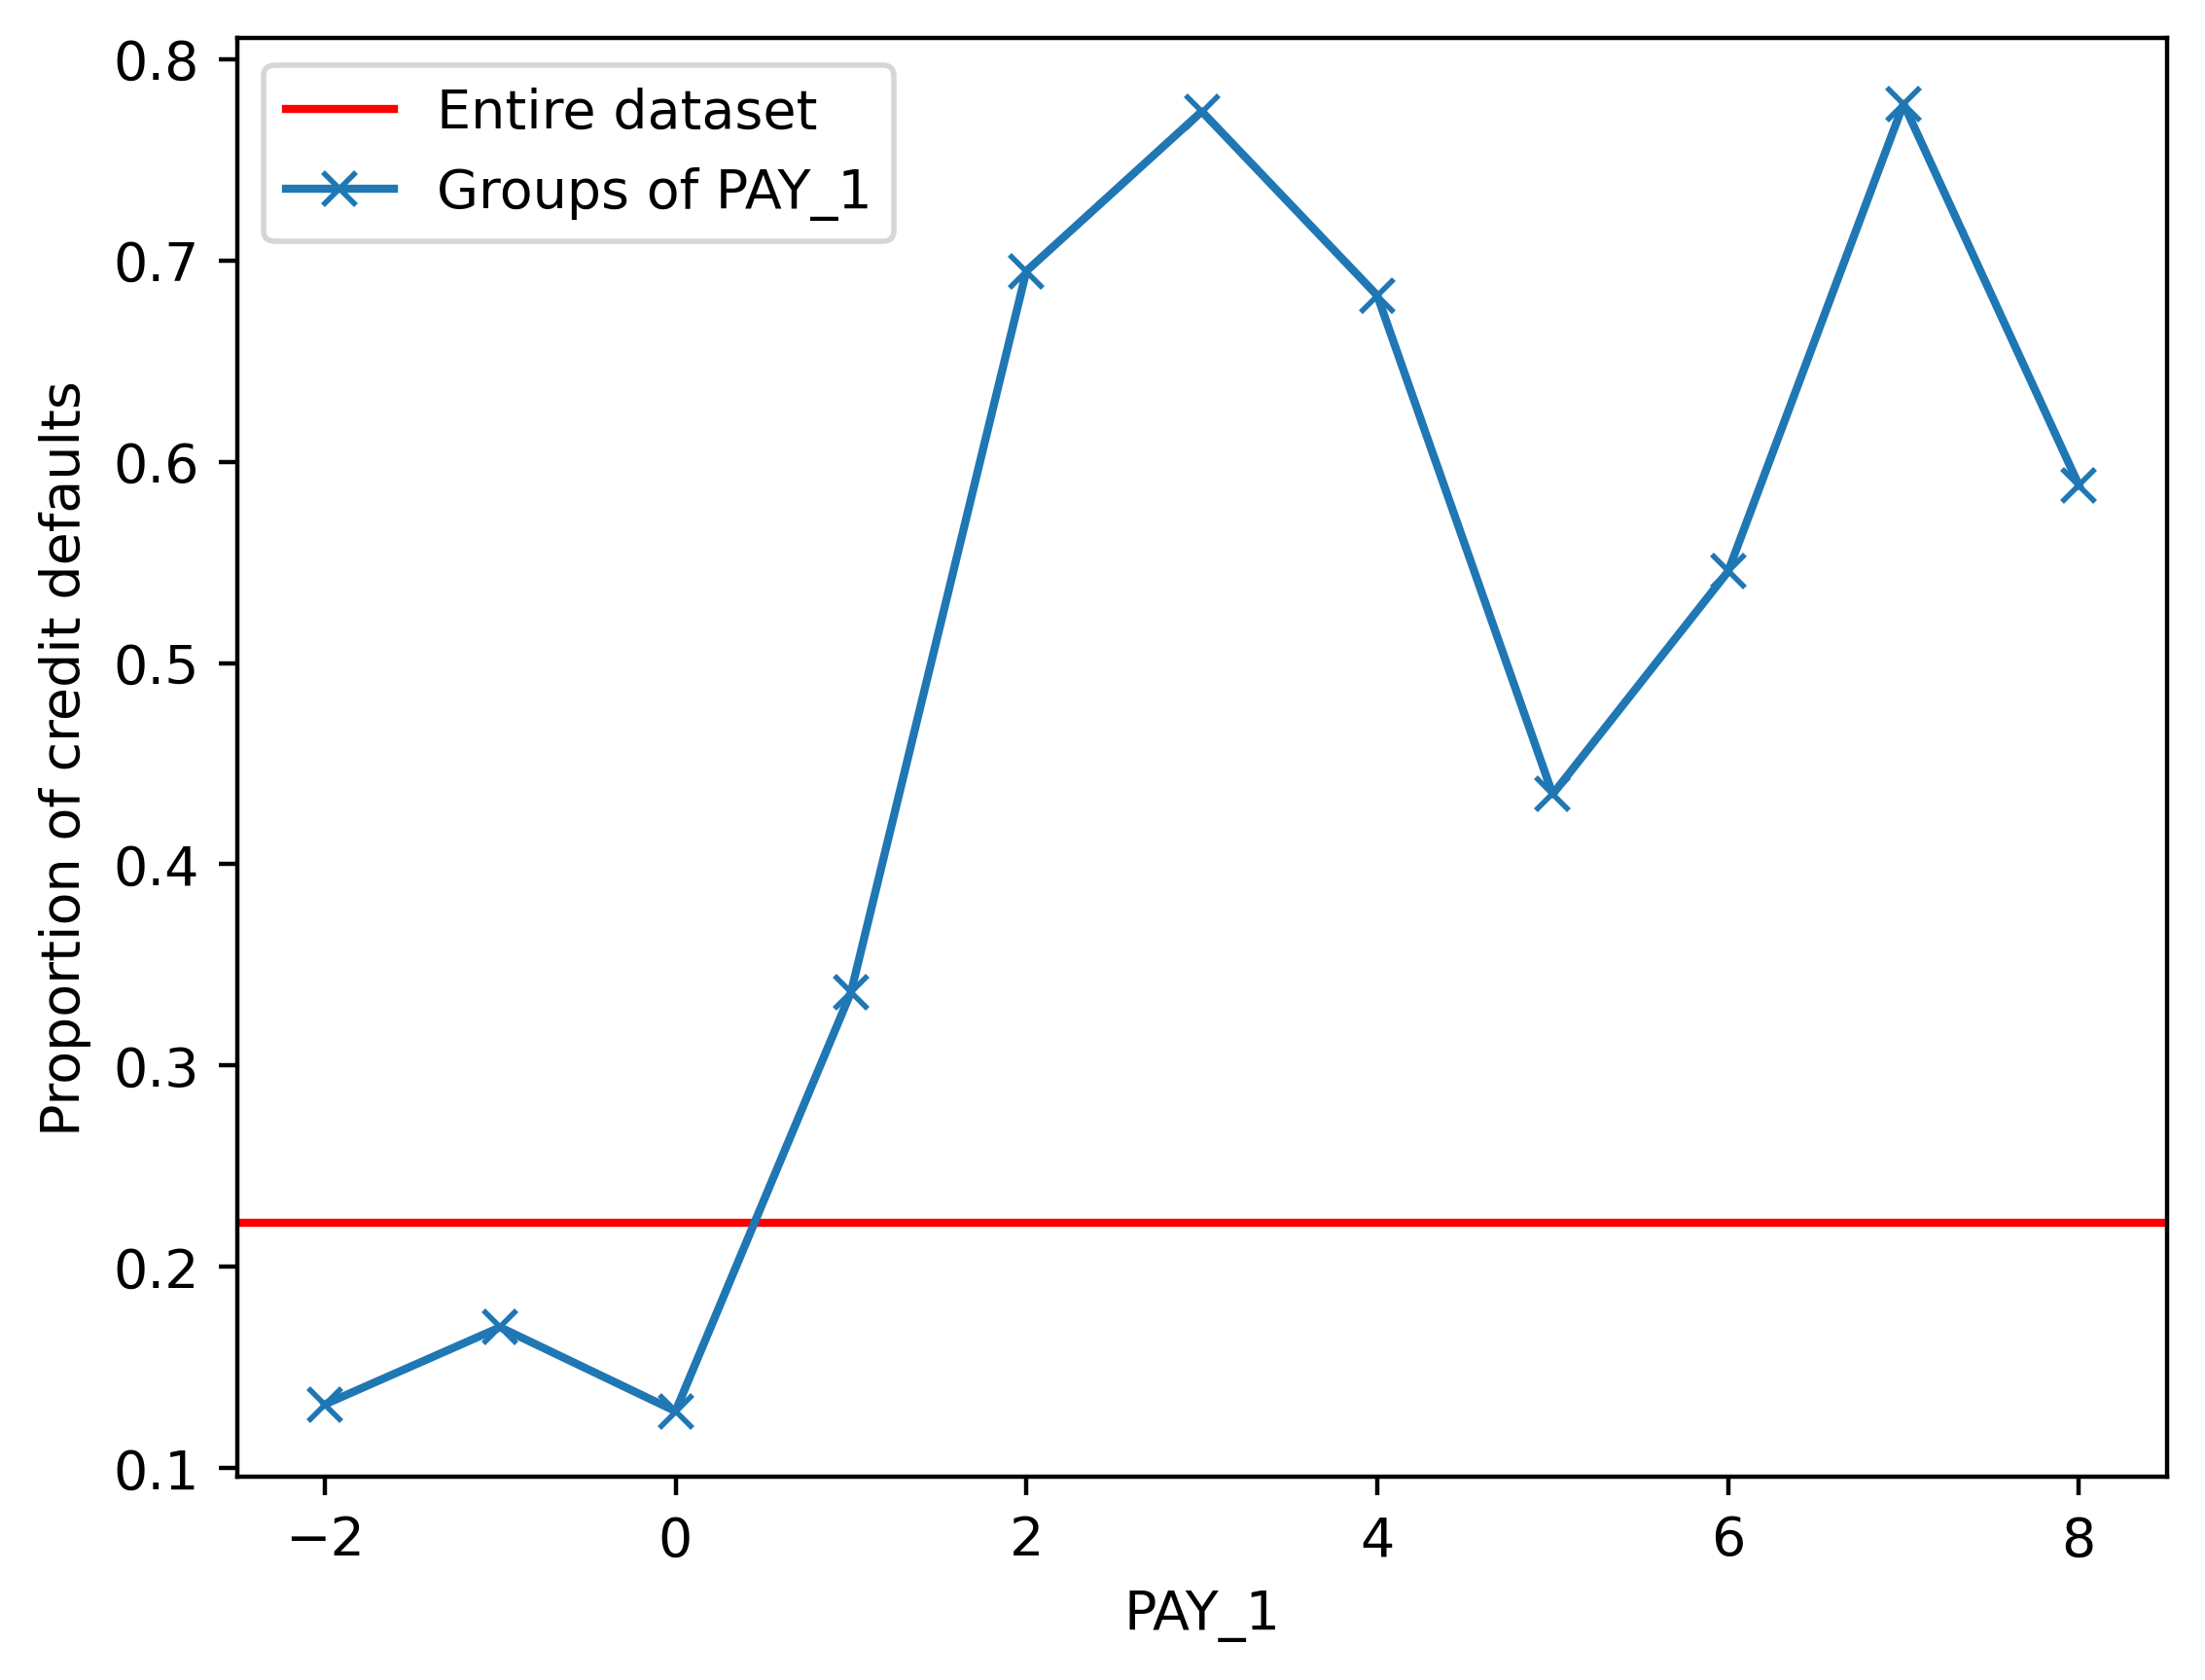

In [25]:
axes = plt.axes()
axes.axhline(overall_default_rate, color='red')
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)  
axes.set_ylabel('Proportion of credit defaults')
axes.legend(['Entire dataset', 'Groups of PAY_1'])

Nossa visualização do status de pagamento revelou uma história clara e provavelmente esperada: quem já inadimpliu apresenta uma tendência maior de fazê-lo novamente. A taxa de inadimplência de contas em boa situação está bem abaixo da taxa geral, que sabemos que era de aproximadamente 22%. No entanto, pelo menos 30% das contas que estavam inadimplentes no último mês estarão inadimplentes novamente no próximo mês de acordo com a verificação. Essa é uma boa referência visual para compartilharmos com o sócio da empresa já que mostra o efeito da característica que talvez seja a mais importante de nosso modelo.

8) Use este código para criar máscaras lógicas para amostras positivas e negativas:

In [26]:
pos_mask = y == 1
neg_mask = y == 0

Para criar nossa plotagem de histograma dupla, geraremos outro objeto "axes" e chamaremos o método ".hist" nele duas vezes para os histogramas das classes positiva e negativa. Forneceremos alguns argumentos de palavra-chave adicionais: "alpha" cria transparência nos histogramas, para que, se eles se sobrepuserem, ainda possamos vê-los, especificaremos as cores. As cores azul e vermelha, com transparência, exibirão uma cor roxa em locais em que os histogramas se sobrepuserem. Uma vez que tivermos os histogramas, giraremos os tick labels do eixo x para torná-los mais legíveis e criaremos outras anotações que devem ser autoexplicativas.

9) Use o código a seguir para criar a plotagem de histograma dupla com as propriedades já mencionadas:

Text(0.5, 1.0, 'Credit limits by response variable')

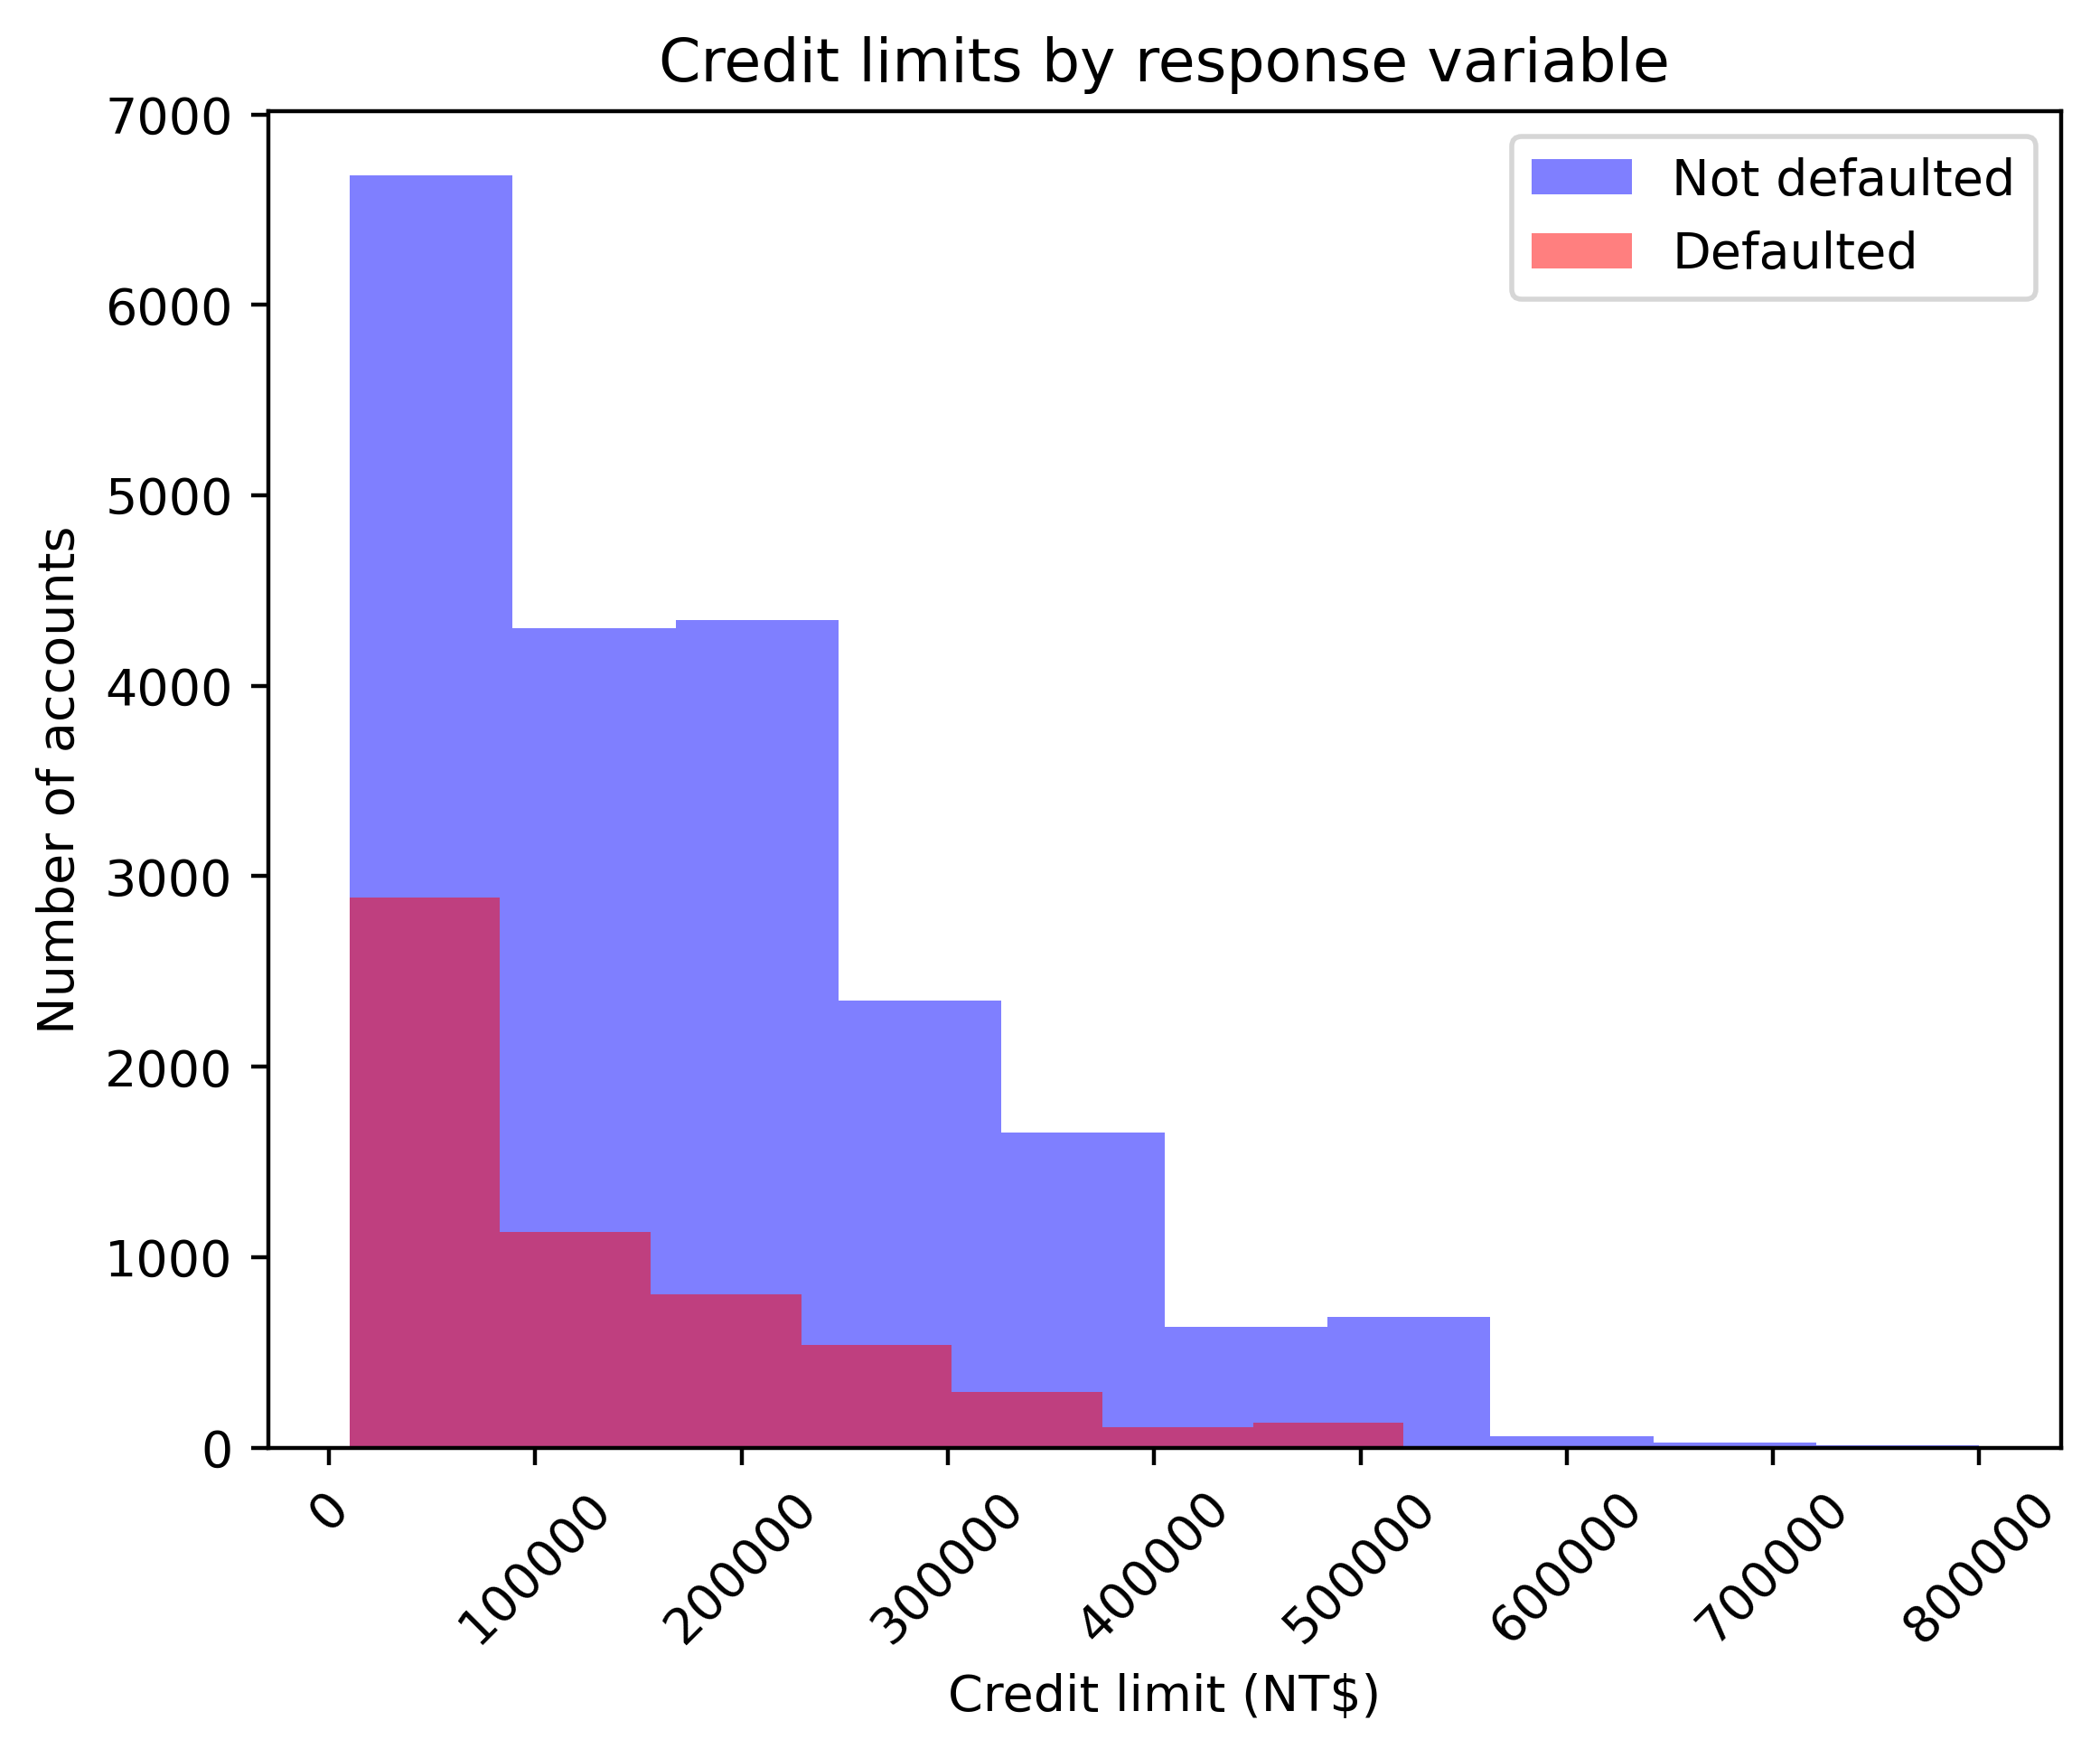

In [27]:
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], alpha=0.5, color='blue')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], alpha=0.5, color='red')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Number of accounts')
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Credit limits by response variable')

Embora essa plotagem tenha ficado com a formatação desejada, ela não é tão explicativa como poderia. Queríamos olhar para ela e constatar que o limite de crédito pode ser uma boa maneira de diferenciar as contas inadimplentes das que não indadimplirão. No entanto, nossa principal percepção visual é a de que o histograma azul é maior que o vermelho. Isso ocorre porque há menos contas inadimplentes.

Seria mais informativo exibir algo sobre como as formas desses histogramas são diferentes, e não apenas seus tamanhos. Para enfatizar esse ponto, podemos tornar igual a área plotada total dos dois histogramas, normalizando-os. O Matplotlib fornece um argumento de palavra-chave que facilita a criação do que poderíamos considerar a versão empírica de uma função de densidade de probabilidade. Isso significa que a integral, ou a área contida dentro de cada histograma, será igual a 1 após a normalização, já que as probabilidades resultam em 1.

Após alguns testes, decidimos criar um histograma com 16 bins. Já que o limite máximo de crédito é NT$800,000, usamos "range" com um incremento de NT$50,000.

10) Crie as bordas dos bins do histograma com este código, que também exibirá a borda de bin final como uma verificação:

In [28]:
bin_edges = list(range(0,850000, 50000))
print(bin_edges[-1])

800000


In [29]:
df['LIMIT_BAL'].max()

800000

O código de plotagem dos histogramas normalizados é semelhante ao anterior, com algumas alterações importantes: o uso da palavra-chave "bins" para definir a localização das bordas dos bins, "density=True" para normalizar os histogramas e alterações nas anotações da plotagem. A parte mais complexa é termos de ajustar os "tick labels de y" para que as alturas dos bins do histograma tenham a interpretação das proporções, que é mais intuitiva que a saída padrão.

Os tick labels de y são os rótulos de texto exibidos perto dos ticks do eixo y e constumam ser simplesmente os valores dos ticks nesses locais. No entanto, pode alterar isso manualmente.

11) Execute este código para produzir histogramas normalizados.

/tmp/ipykernel_3472/1972270715.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.round(y_ticks*50000,2))


Text(0.5, 1.0, 'Normalized distributions of credit limits by response variable')

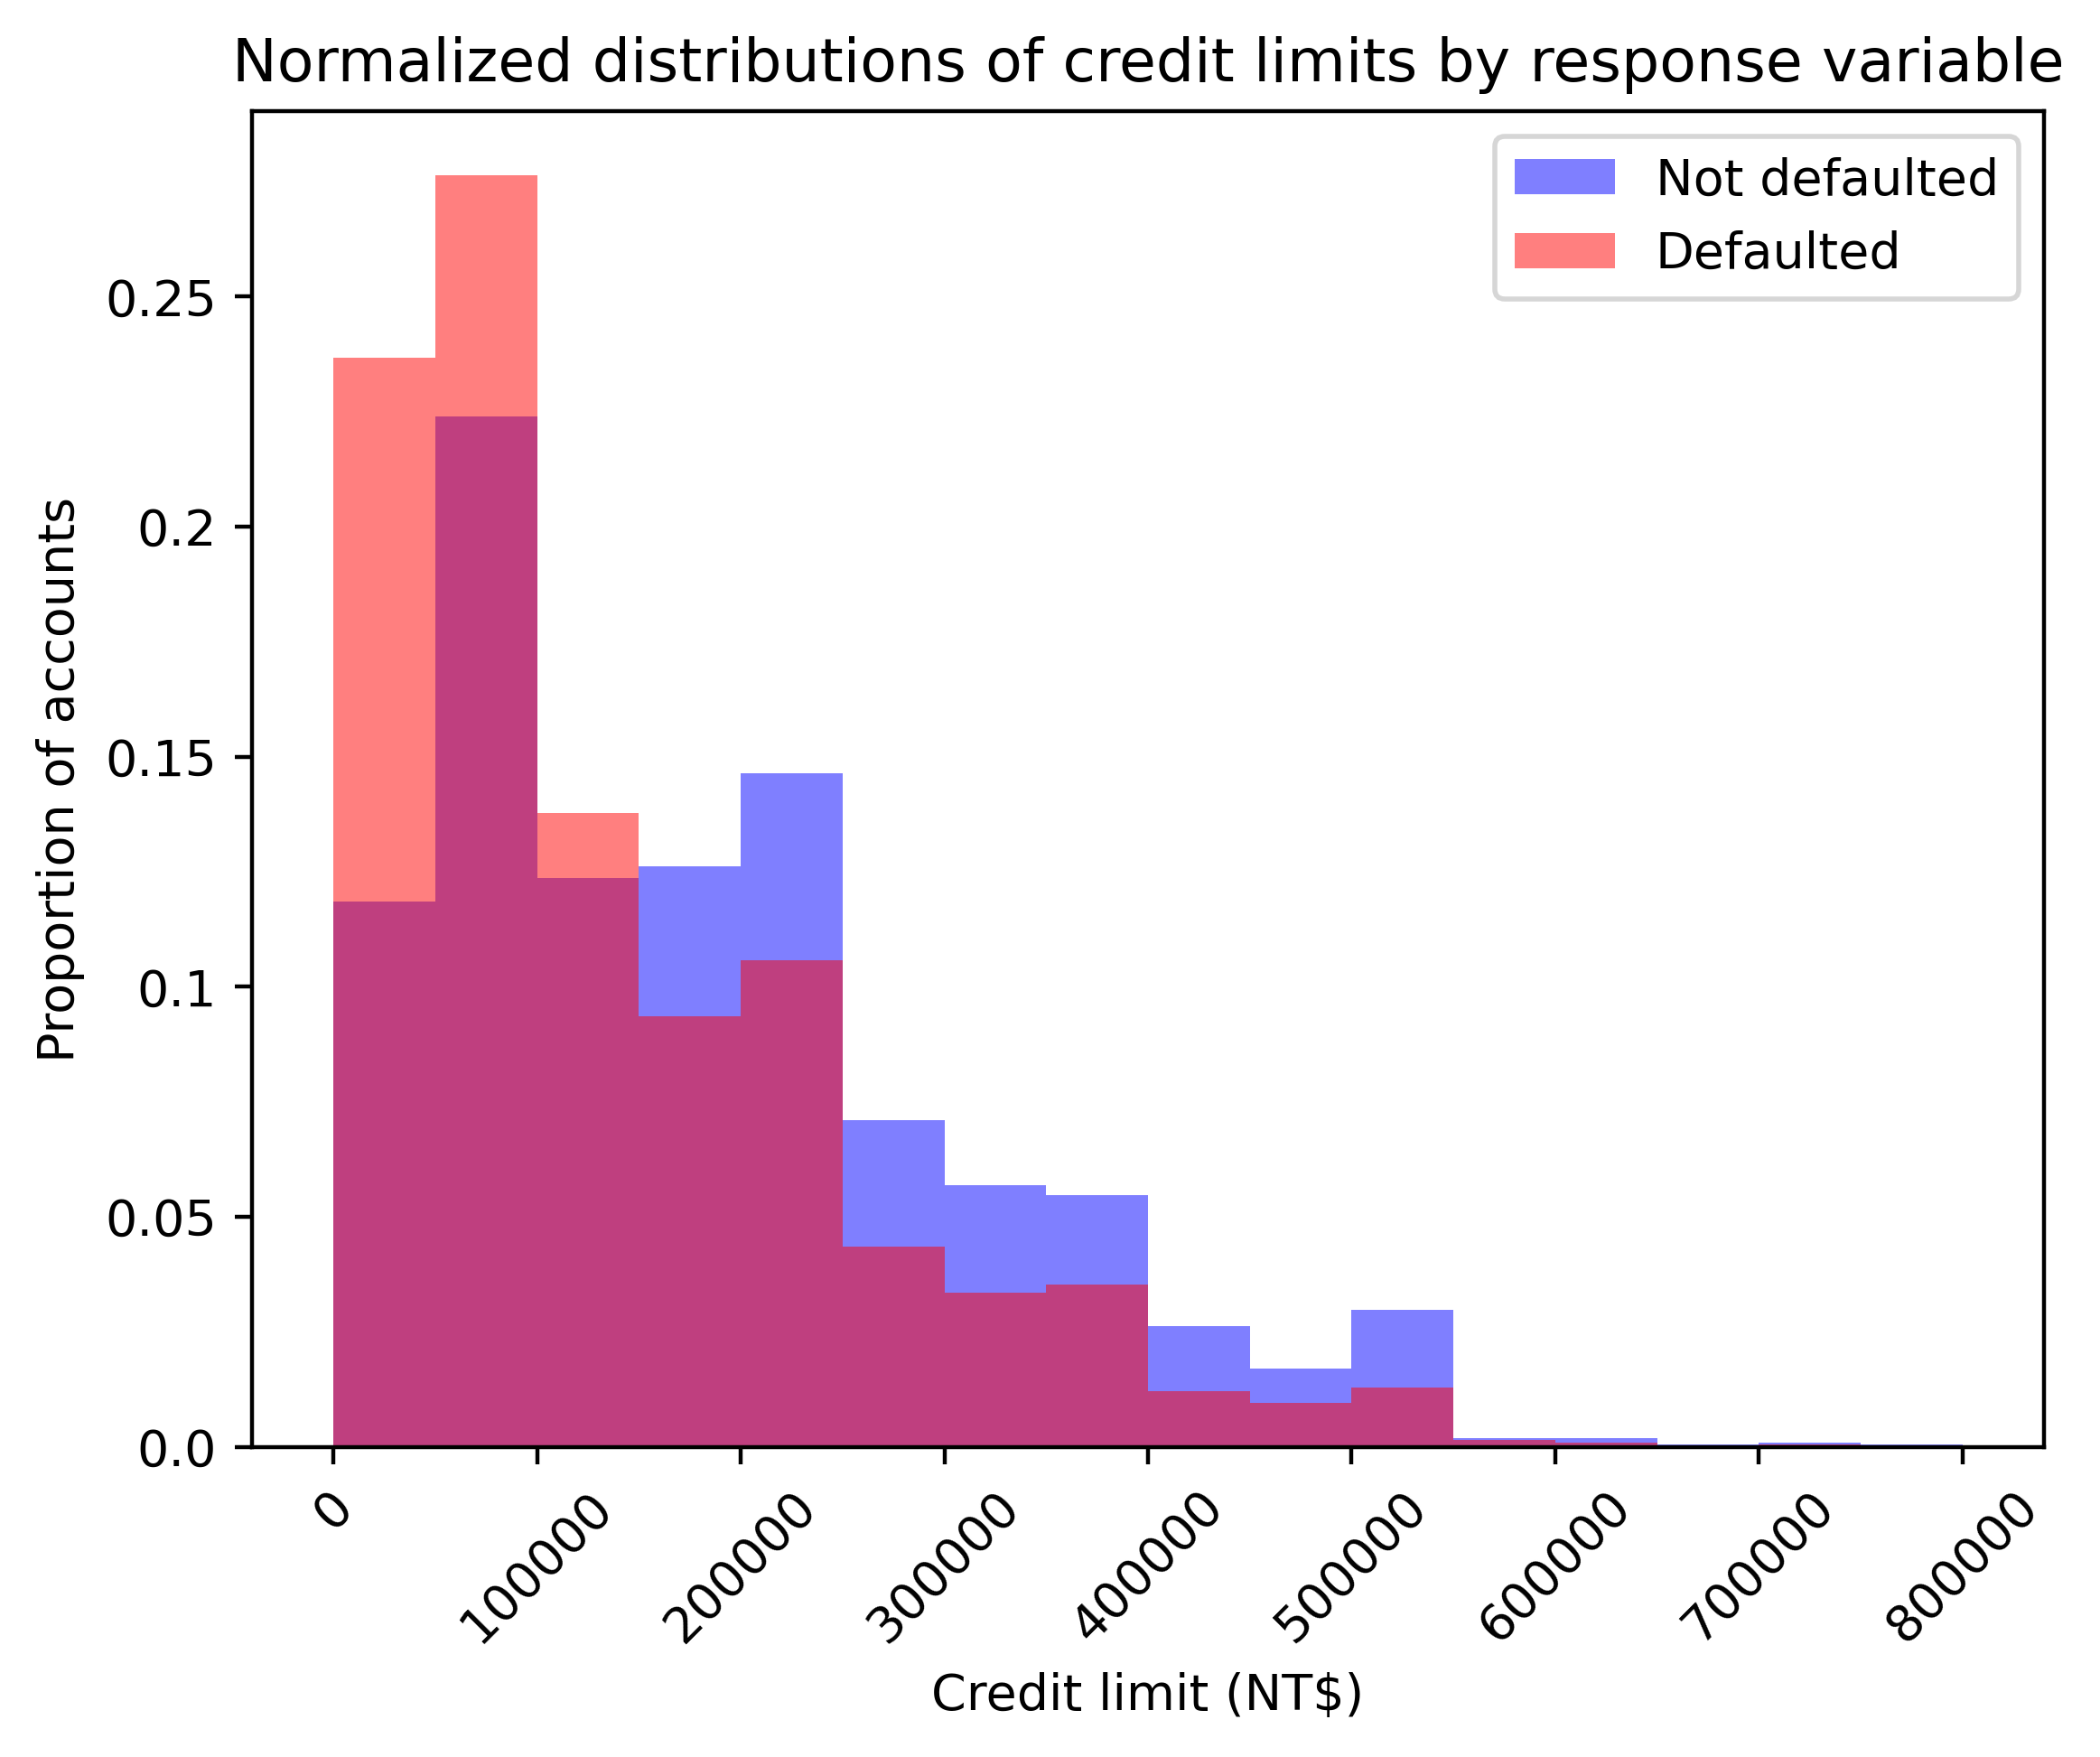

In [30]:
mpl.rcParams['figure.dpi'] = 400 
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], bins=bin_edges, alpha=0.5, density=True, color='blue')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], bins=bin_edges, alpha=0.5, density=True, color='red')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Proportion of accounts')
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks*50000,2))
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Normalized distributions of credit limits by response variable')

### Seleção de características univariada: o que ela pode ou não fazer
    
Aprenderemos técnicas para percorrer as características uma a uma e ver se elas têm poder preditivo. Essa é uma ótima primeira etapa, se já tem a características que sejam boas preditoras da variável de resultado, talvez não precise gastar muito tempo considerando as características antes da modelagem.

### Entendendo a regressão logística com sintaxe de funções Python e a função sigmóide

Uma função matemática que é importante para a regressão logística, chamada "sigmóide". Essa função também pode ser chamada de "Função Logística". 

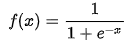 

=> f(x) = sigmoid(x)

Como as entradas podem ser passadas para a função "np.exp". Já que a implementação do NumPy é 'vetorizada', essa função pode receber tanto número individuais quanto arrays ou matrizes como entrada. Primeiro calculamos o exponencial de 1, que mostra o valor aproximado de e, e depois 'e**0', que é claro é igual 1, como ocorre com a potência zero de qualquer base:

In [31]:
np.exp(1)

2.718281828459045

In [32]:
np.exp(0)

1.0

Para ilustrar a implementação vetorizada de 'np.exp', criaremos um array de números usando a função 'linspace' do NumPy. Essa função recebe como entrada os pontos inicial e final de um intervalo e o número de valores que queremos dele para criar um array com esses valores linearmente espaçados. Ela desempenha um papel semelhante ao da função Python 'range', mas também pode produzir valores decimais:

In [33]:
X_exp = np.linspace(-4, 4, 81)
print(X_exp[:5])
print(X_exp[-5:])

[-4.  -3.9 -3.8 -3.7 -3.6]
[3.6 3.7 3.8 3.9 4. ]


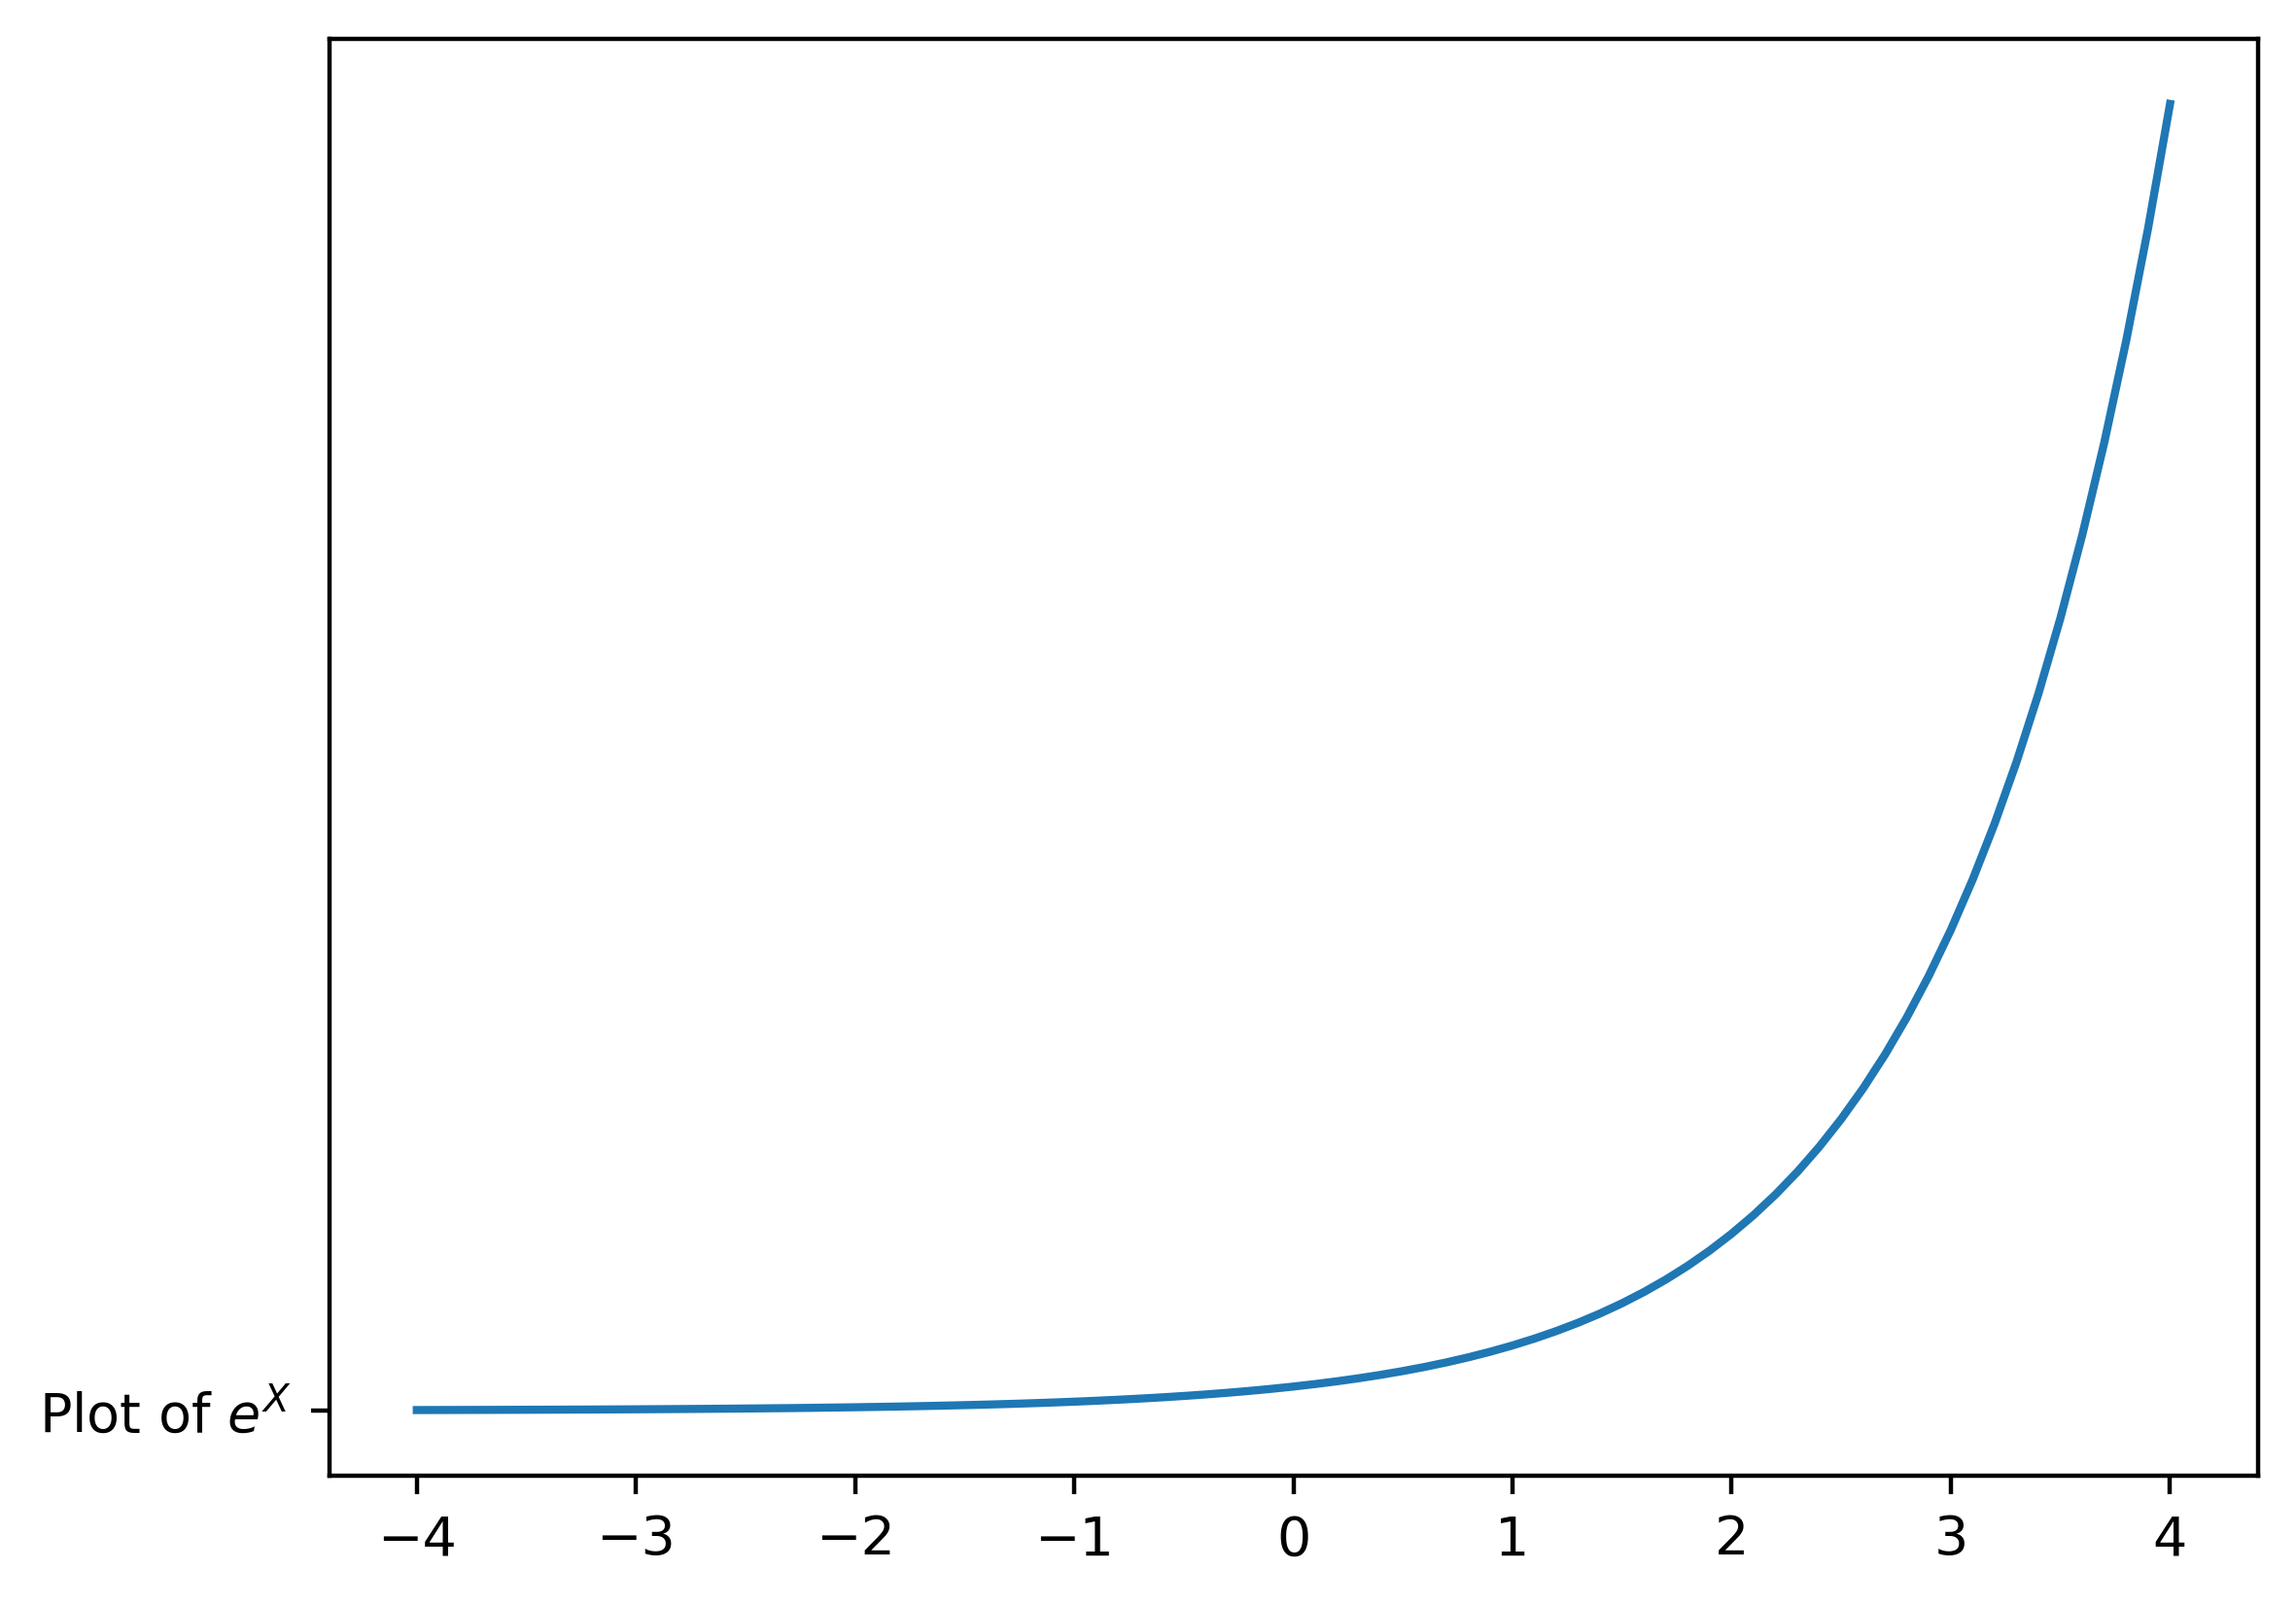

In [34]:
Y_exp = np.exp(X_exp)
plt.plot(X_exp, Y_exp)
plt.plot('Plot of $e^X$')

Já que 'np.exp' é vetorizada, calculará eficientemente o exponencial de todo o array de uma só vez. Aqui está o código, com a saída, que calcula o exponencial de nosso array X_exp e examina os cinco primeiros valores:

In [35]:
Y_exp = np.exp(X_exp)
Y_exp[:5]

array([0.01831564, 0.02024191, 0.02237077, 0.02472353, 0.02732372])

### Exercício 13: Plotando a função sigmóide
    
Neste exercício, usaremos as variáveis X_exp e Y_exp, criadas anteriormente, para gerar uma plotagem da função exponencial no intervalo [-4, 4].Será definida uma função para sigmóide, criaremos uma plotagem dela e consideraremos qual sua relação com a função exponenencial.

1) Use esse código para plotar a função exponencial

Text(0.5, 1.0, 'Plot of $e^X$')

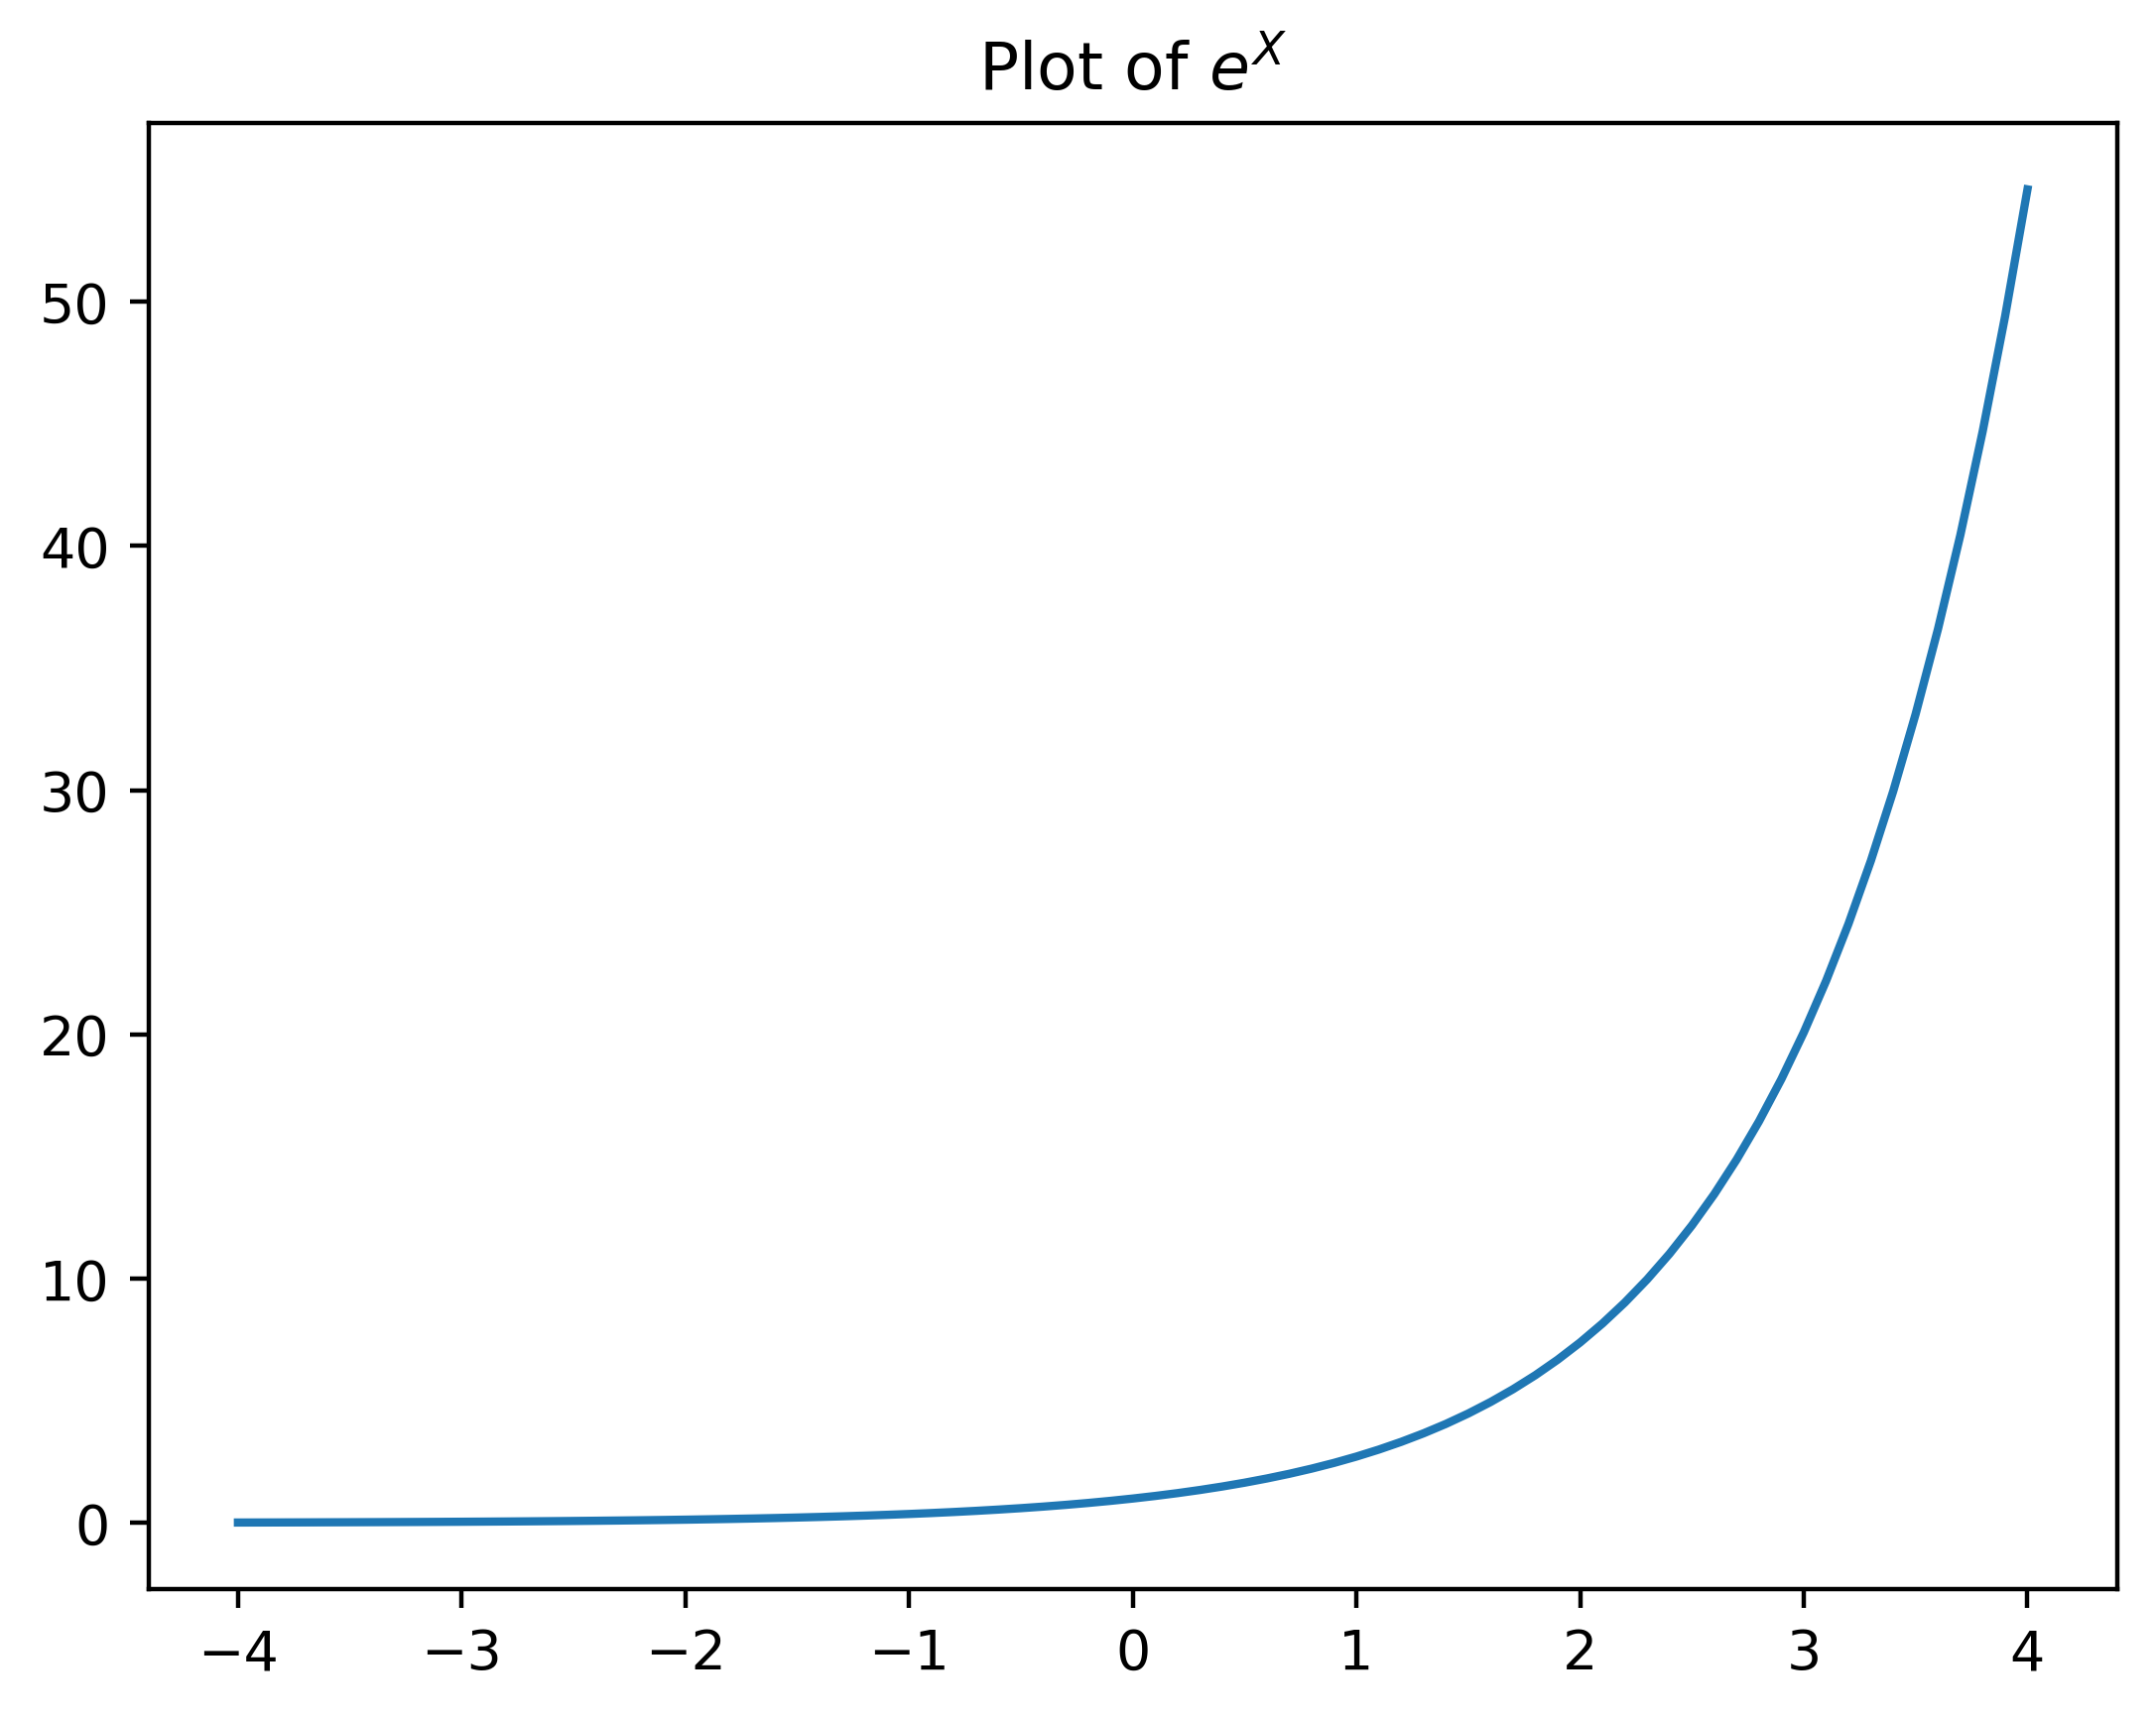

In [36]:
plt.plot(X_exp, Y_exp)
plt.title('Plot of $e^X$')

2) Execute este código para ver a plotagem de 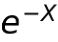

Text(0.5, 1.0, 'plot of $e^{-X}$')

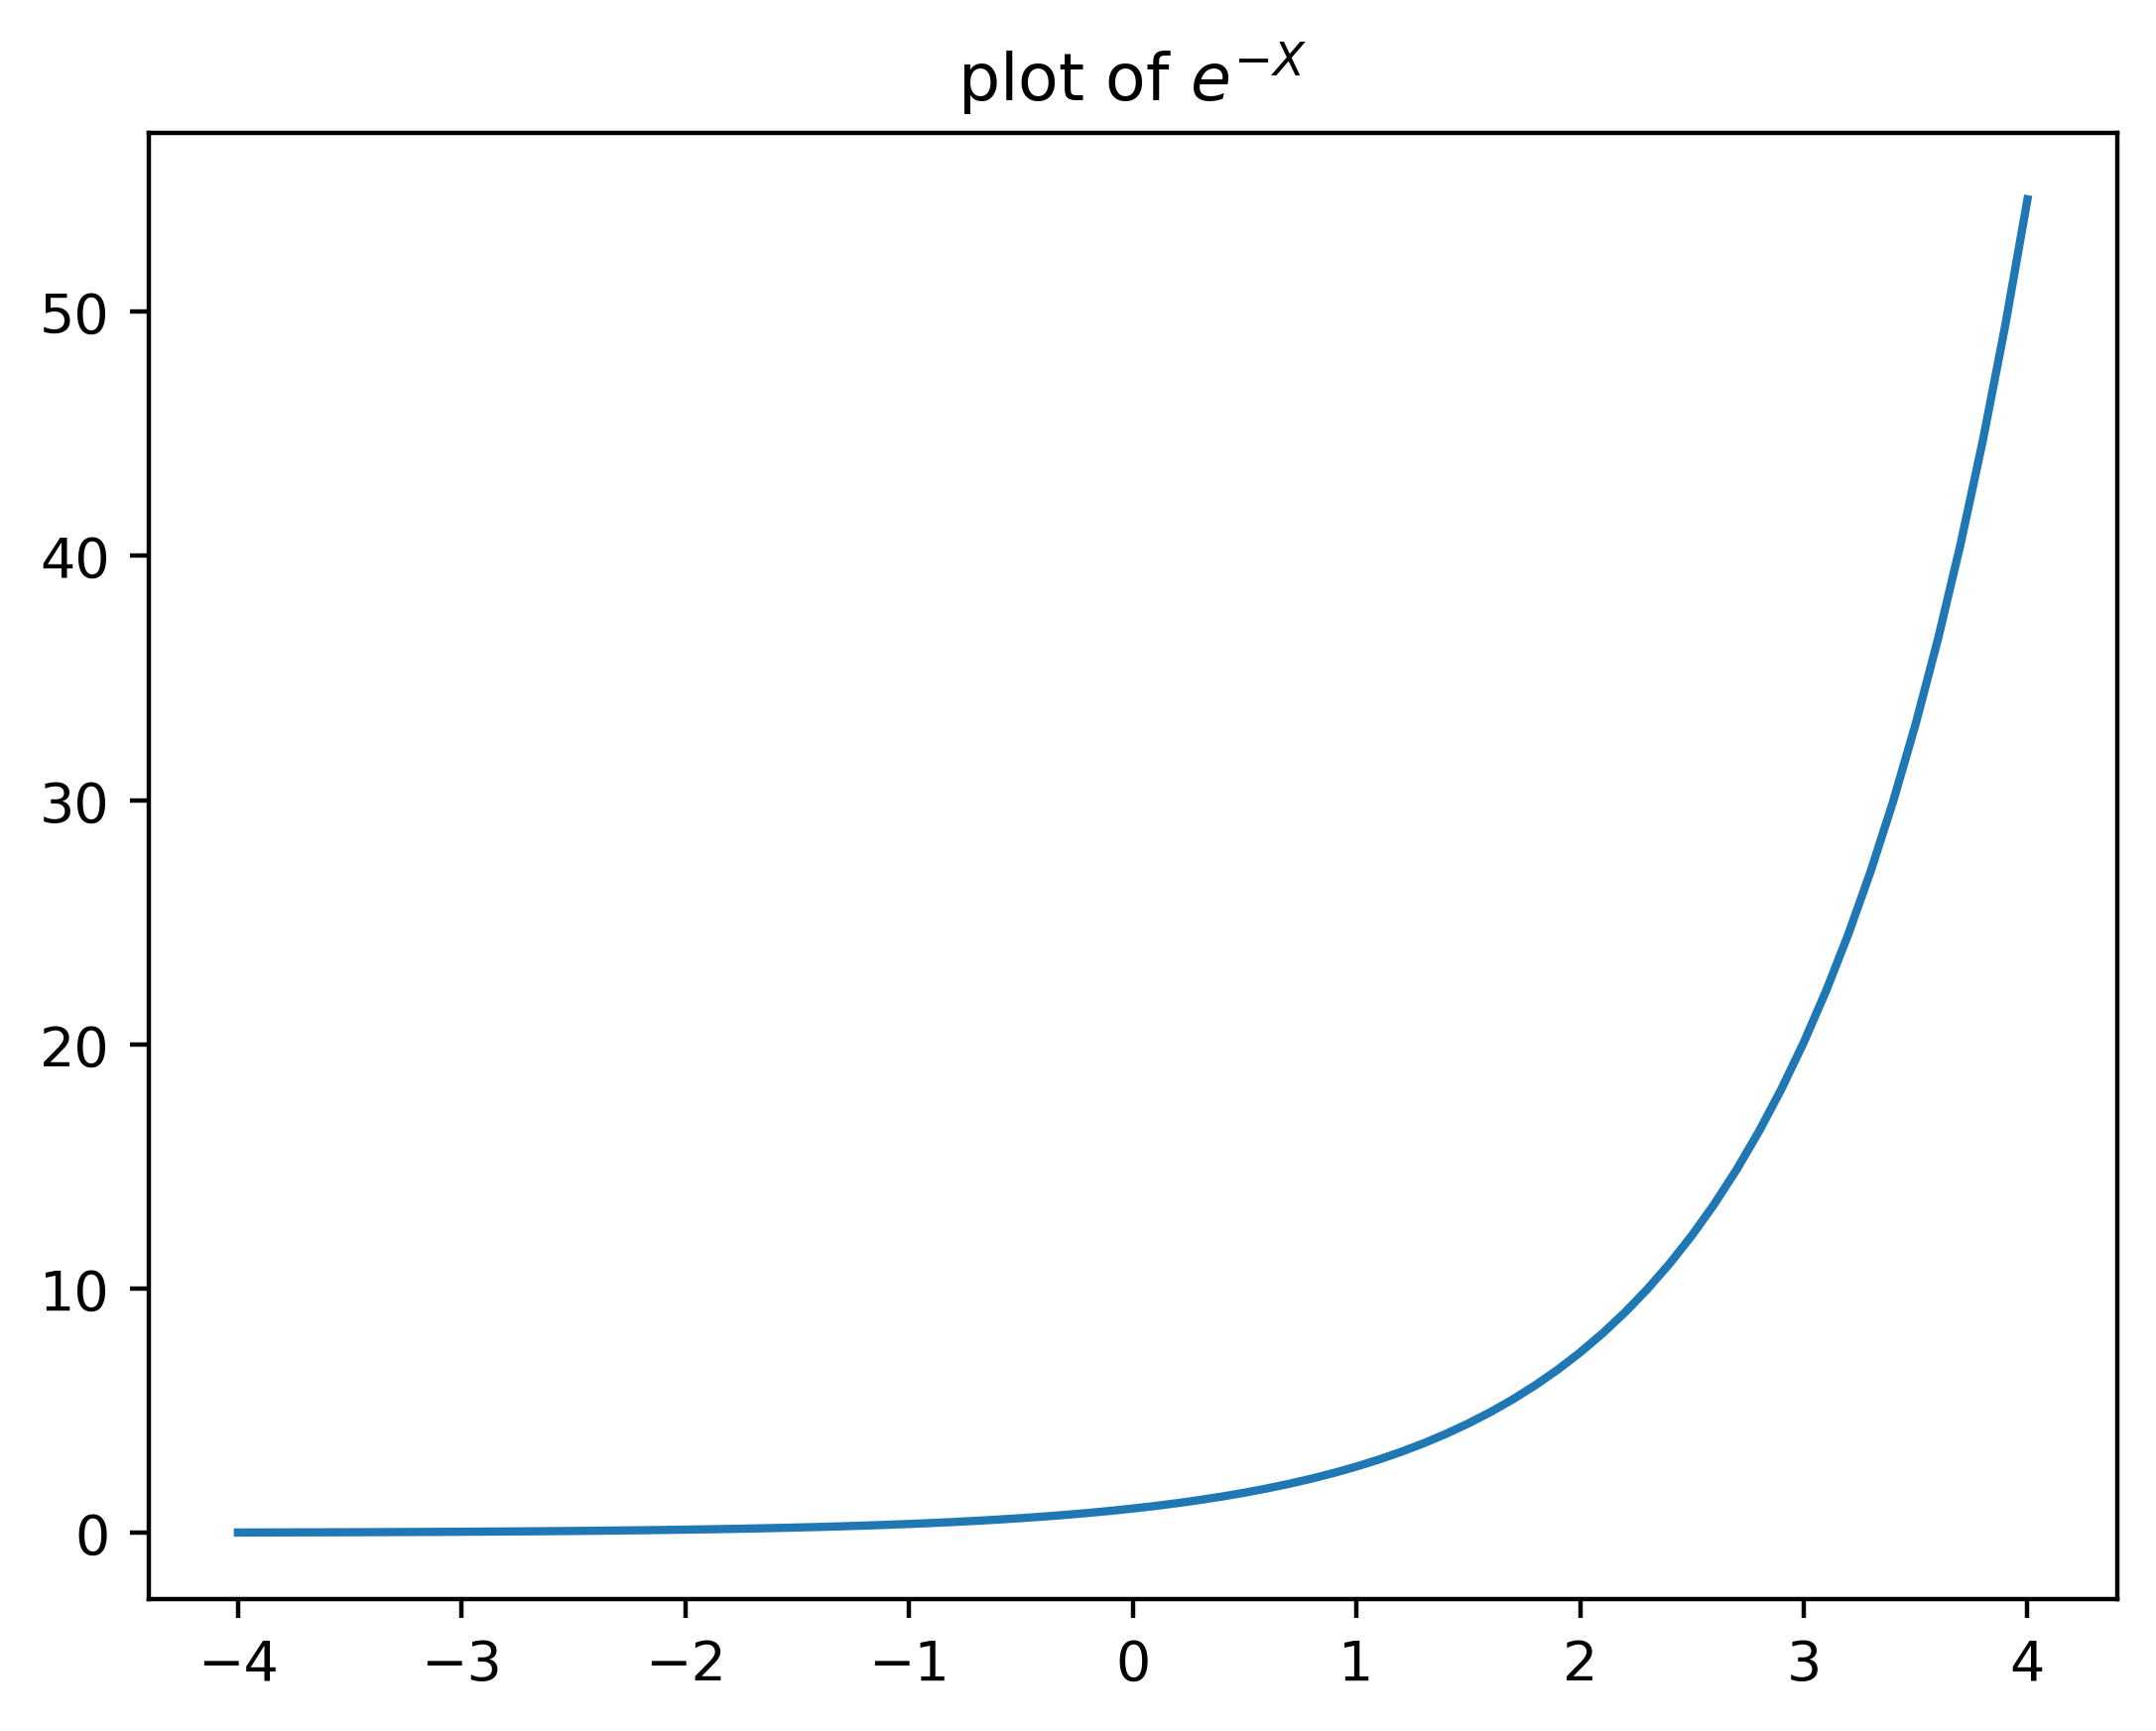

In [37]:
Y_exp = np.exp(X_exp)
plt.plot(X_exp, Y_exp)
plt.title('plot of $e^{-X}$')

3) Defina uma função sigmóide como esta:

In [38]:
def sigmoid(X):
    Y = 1 / (1 + np.exp(-X))
    return Y

4) Crie um intervalo maior de valores de x para usar na plotagem e represente a função sigmóide. Use este código:

Text(0.5, 1.0, 'The sigmoid function')

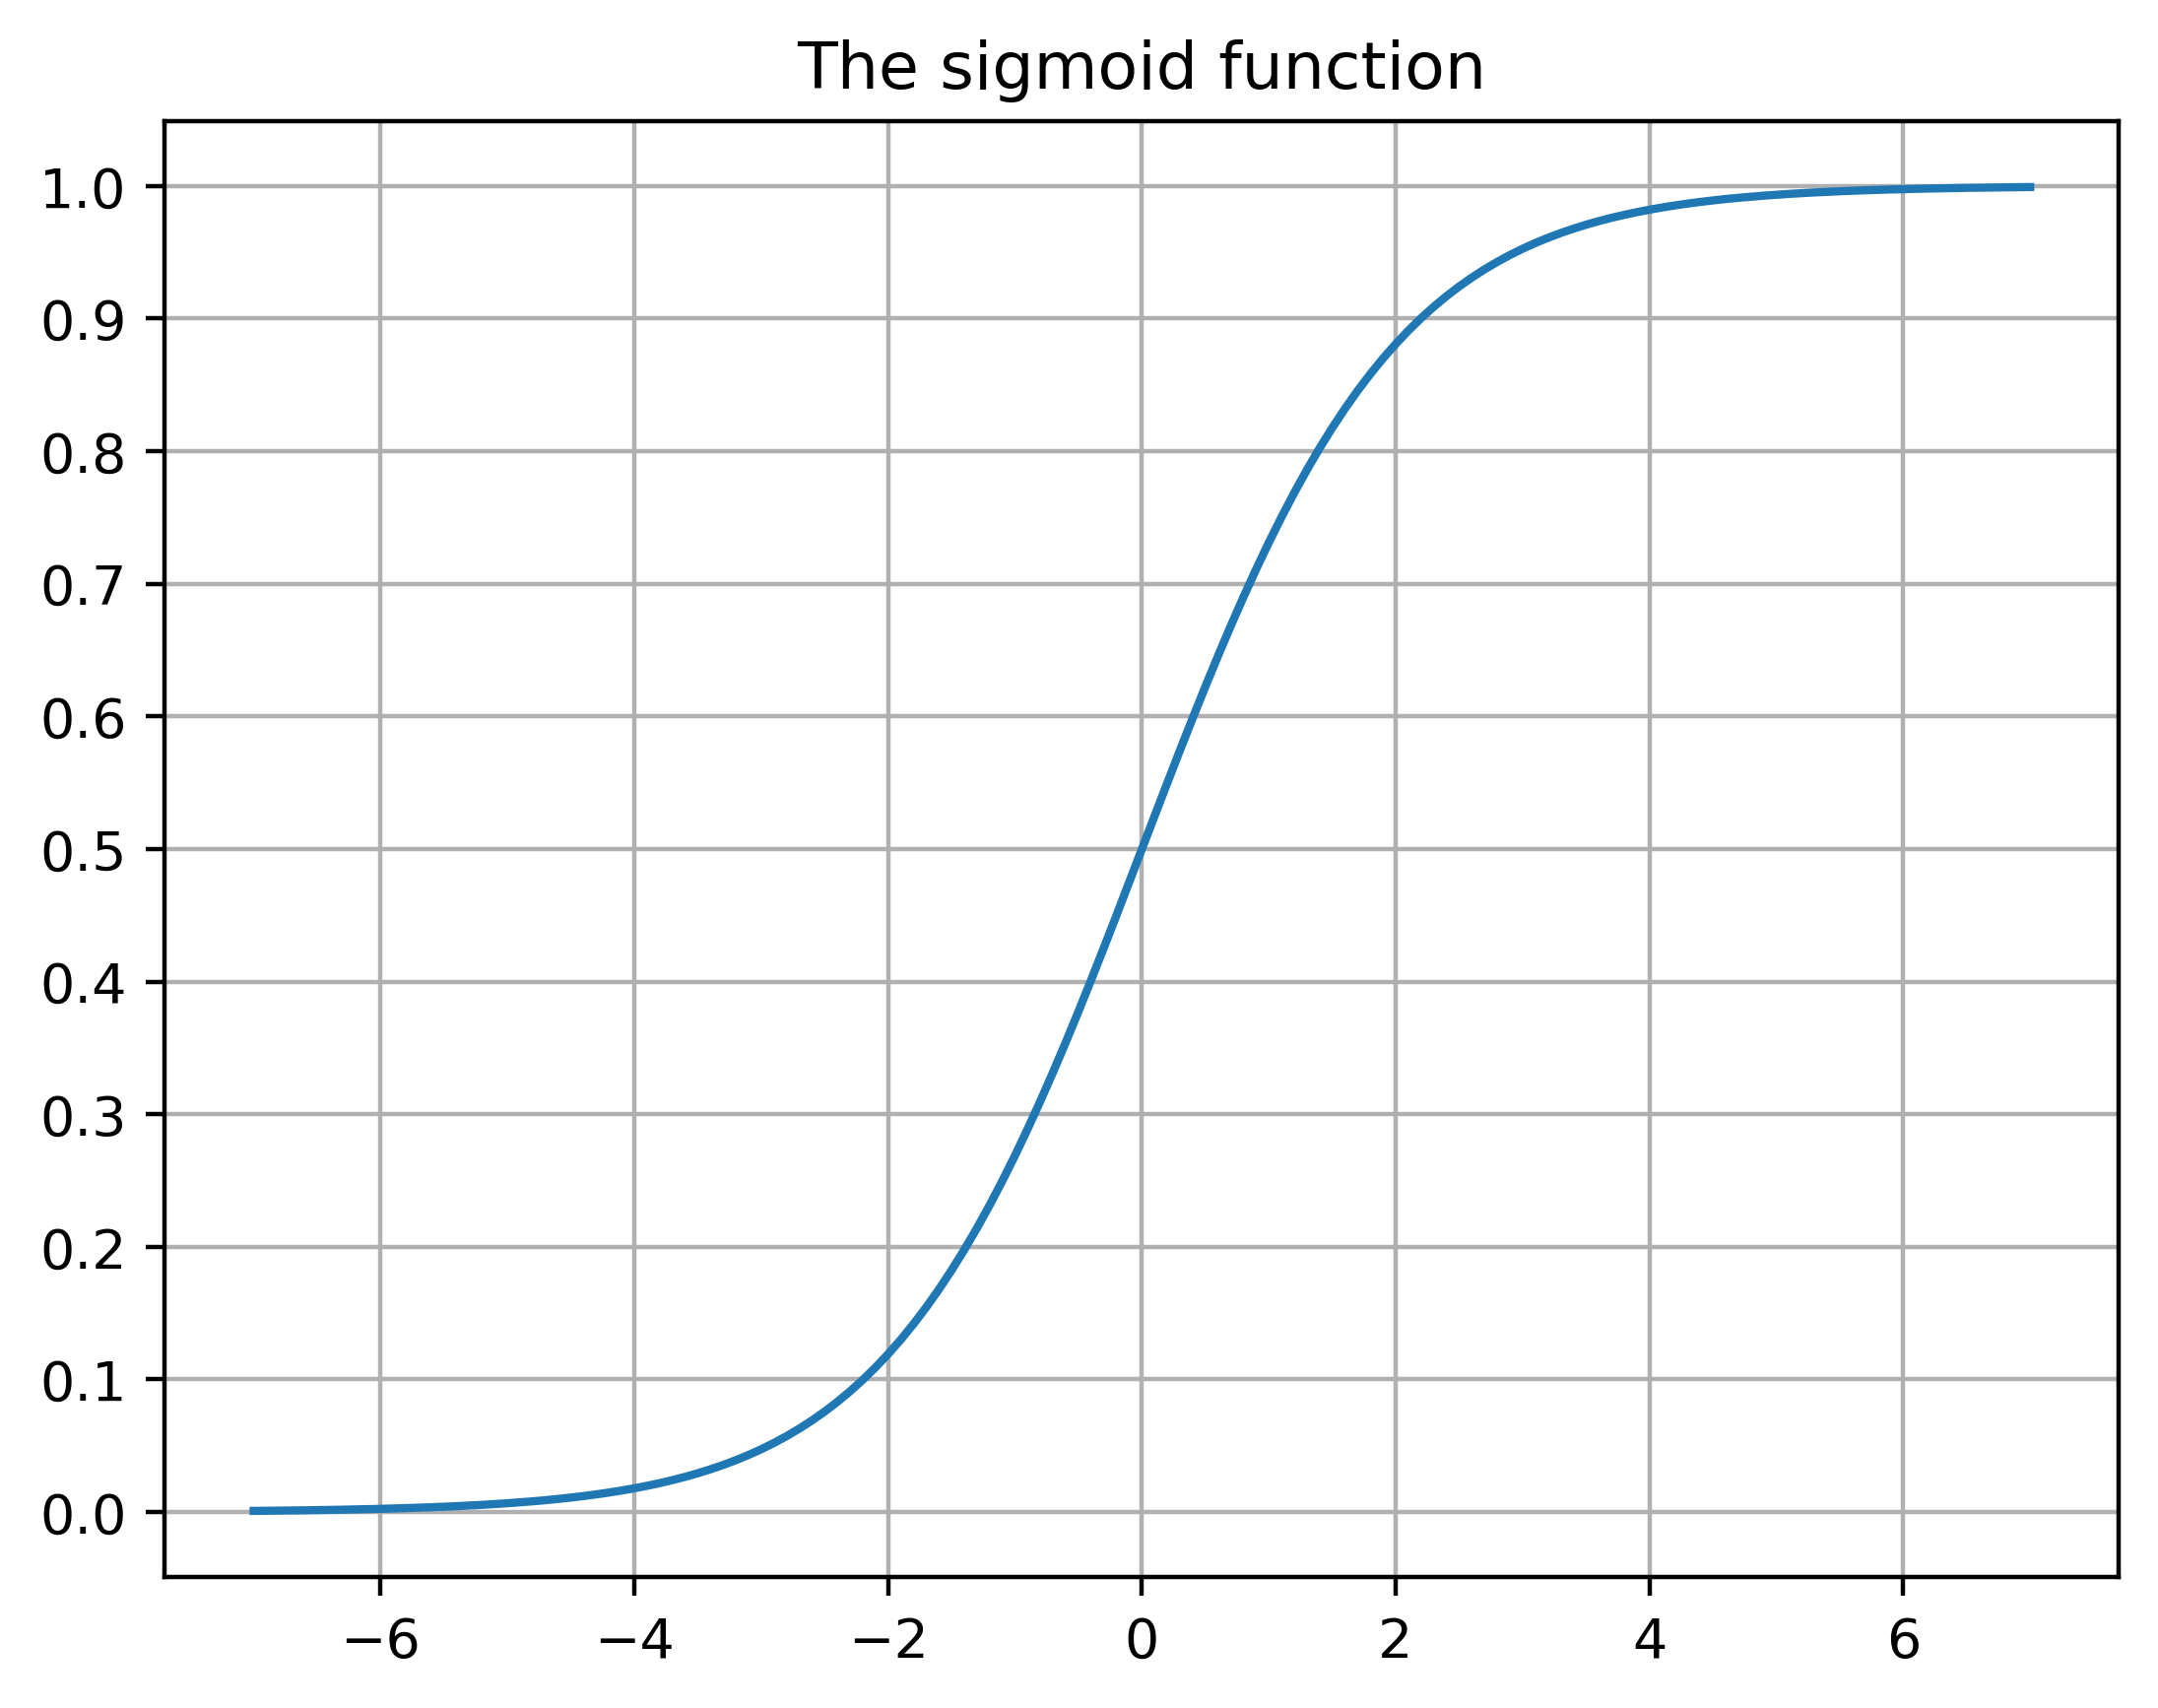

In [39]:
X_sig = np.linspace(-7, 7, 141)
Y_sig = sigmoid(X_sig)
plt.plot(X_sig, Y_sig)
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
plt.title('The sigmoid function')

### Escopo das funções

Quando começa a usar funções, deve tomar consciência do conceito de 'escopo'. Observe que, quando escrevemos a função 'sigmóide', criamos uma variável 'Y', dentro da função. Variáveis criadas dentro de funções são diferentes das criadas fora delas. Elas são criadas e destruídas dentro da própria função, quando ela é chamada. Essas variáveis são consideradas de escopo 'local': elas só funcionam na função.

As variáveis globais criadas fora de funções ficam disponíveis dentro do escopo local destas, mesmo se não forem fornecidas como parâmetros da função. 

Aqui estamos demonstrando a criação de uma variável como escopo global fora de uma função e o acesso a ela dentro da função. A função não recebe parâmetros, mas, como pode ver, ela pode usar o valor da variável global para criar uma saída:

In [40]:
example_global_variable = 1

In [41]:
def example_function():
    output = example_global_variable + 1
    return(output)

In [42]:
example_function()

2

Por que a regressão logística é considerada um modelo linear?

Um modelo é considerado linear quando a transformação usada no cálculo da previsão é uma 'Combinação linear' das características. As possibilidades de uma combinação linear ocorrem quando cada característica pode ser multiplicada por uma constante numérica, esses termos podem ser somados, e uma constante adicional também pode ser somada. Por exemplo, em um modelo simples com duas características, X1 e X2, uma combinação linear teria esta forma:

###### Combinação Linear de X1 e X2 = O0 + O1+X1 + O2+X2

##### Exercício 14 - Examinando a conveniência das características para a regressão logística

Nesse exercício, avaliaremos a conveniência do uso de 'PAY_1' na regressão logística. Faremos isso examinando o logaritmo das chances de inadimplência dentro desses grupos para ver se a variável de resposta é linear, como supõe formalmente a regressão logística. Execute as etapas a seguir para fazer o exercício:

1) Veja se ainda consegue acessar as variáveis do 'Exercício 12', Visualizando o relacionamento entre as características e a resposta no notebook examinando com o código a seguir o DataFrame do valor de média da variável de resposta para diferentes valores de 'PAY_1':

In [43]:
group_by_pay_mean_y # Taxa de inadimplência dentro de grupos de valores de PAY_1, probabilidade de não pagamento.

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


2) Extraia os valores de média de variável de resposta para esses grupos e insira-os em uma variável, 'p', representando a probabilidade de inadimplência:

In [44]:
p = group_by_pay_mean_y['default payment next month'].values

3) Crie uma probabilidade, 'q', de inexistência de inadimplência. Já que há apenas dois resultados possíveis nesse problema binário, e a soma das probabilidades é '1', é muito fácil calcular 'q'. Exiba também os valores de 'p' e 'q' para confirmar:

In [45]:
q = 1-p
print(p)
print(q)

[0.13166397 0.17000198 0.12829525 0.33639988 0.69470143 0.7739726
 0.68253968 0.43478261 0.54545455 0.77777778 0.58823529]
[0.86833603 0.82999802 0.87170475 0.66360012 0.30529857 0.2260274
 0.31746032 0.56521739 0.45454545 0.22222222 0.41176471]


4) Calcule a razão de possibilidades de 'p' e 'q', assim como o logaritmo das chances, usando a função de logaritmo natural do NumPy:

In [46]:
odds_ratio = p / q
odds_ratio

array([0.15162791, 0.20482215, 0.14717742, 0.50693161, 2.27548209,
       3.42424242, 2.15      , 0.76923077, 1.2       , 3.5       ,
       1.42857143])

In [47]:
log_odds = np.log(odds_ratio)
log_odds

array([-1.88632574, -1.58561322, -1.91611649, -0.67937918,  0.82219194,
        1.23088026,  0.76546784, -0.26236426,  0.18232156,  1.25276297,
        0.35667494])

5) Para plotar o logaritmo das chances para os valores da característica, podemos obter os valores no índice do DataFrame que contém 'groupby/mean'. Pode exibir o índice dessa forma:

In [48]:
group_by_pay_mean_y.index

Int64Index([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='PAY_1')

6) Crie uma plotagem semelhante à que criamos anteriormente, para exibir o logaritmo das chances dos valores da característica.

Text(0.5, 0, 'Values od PAY_1')

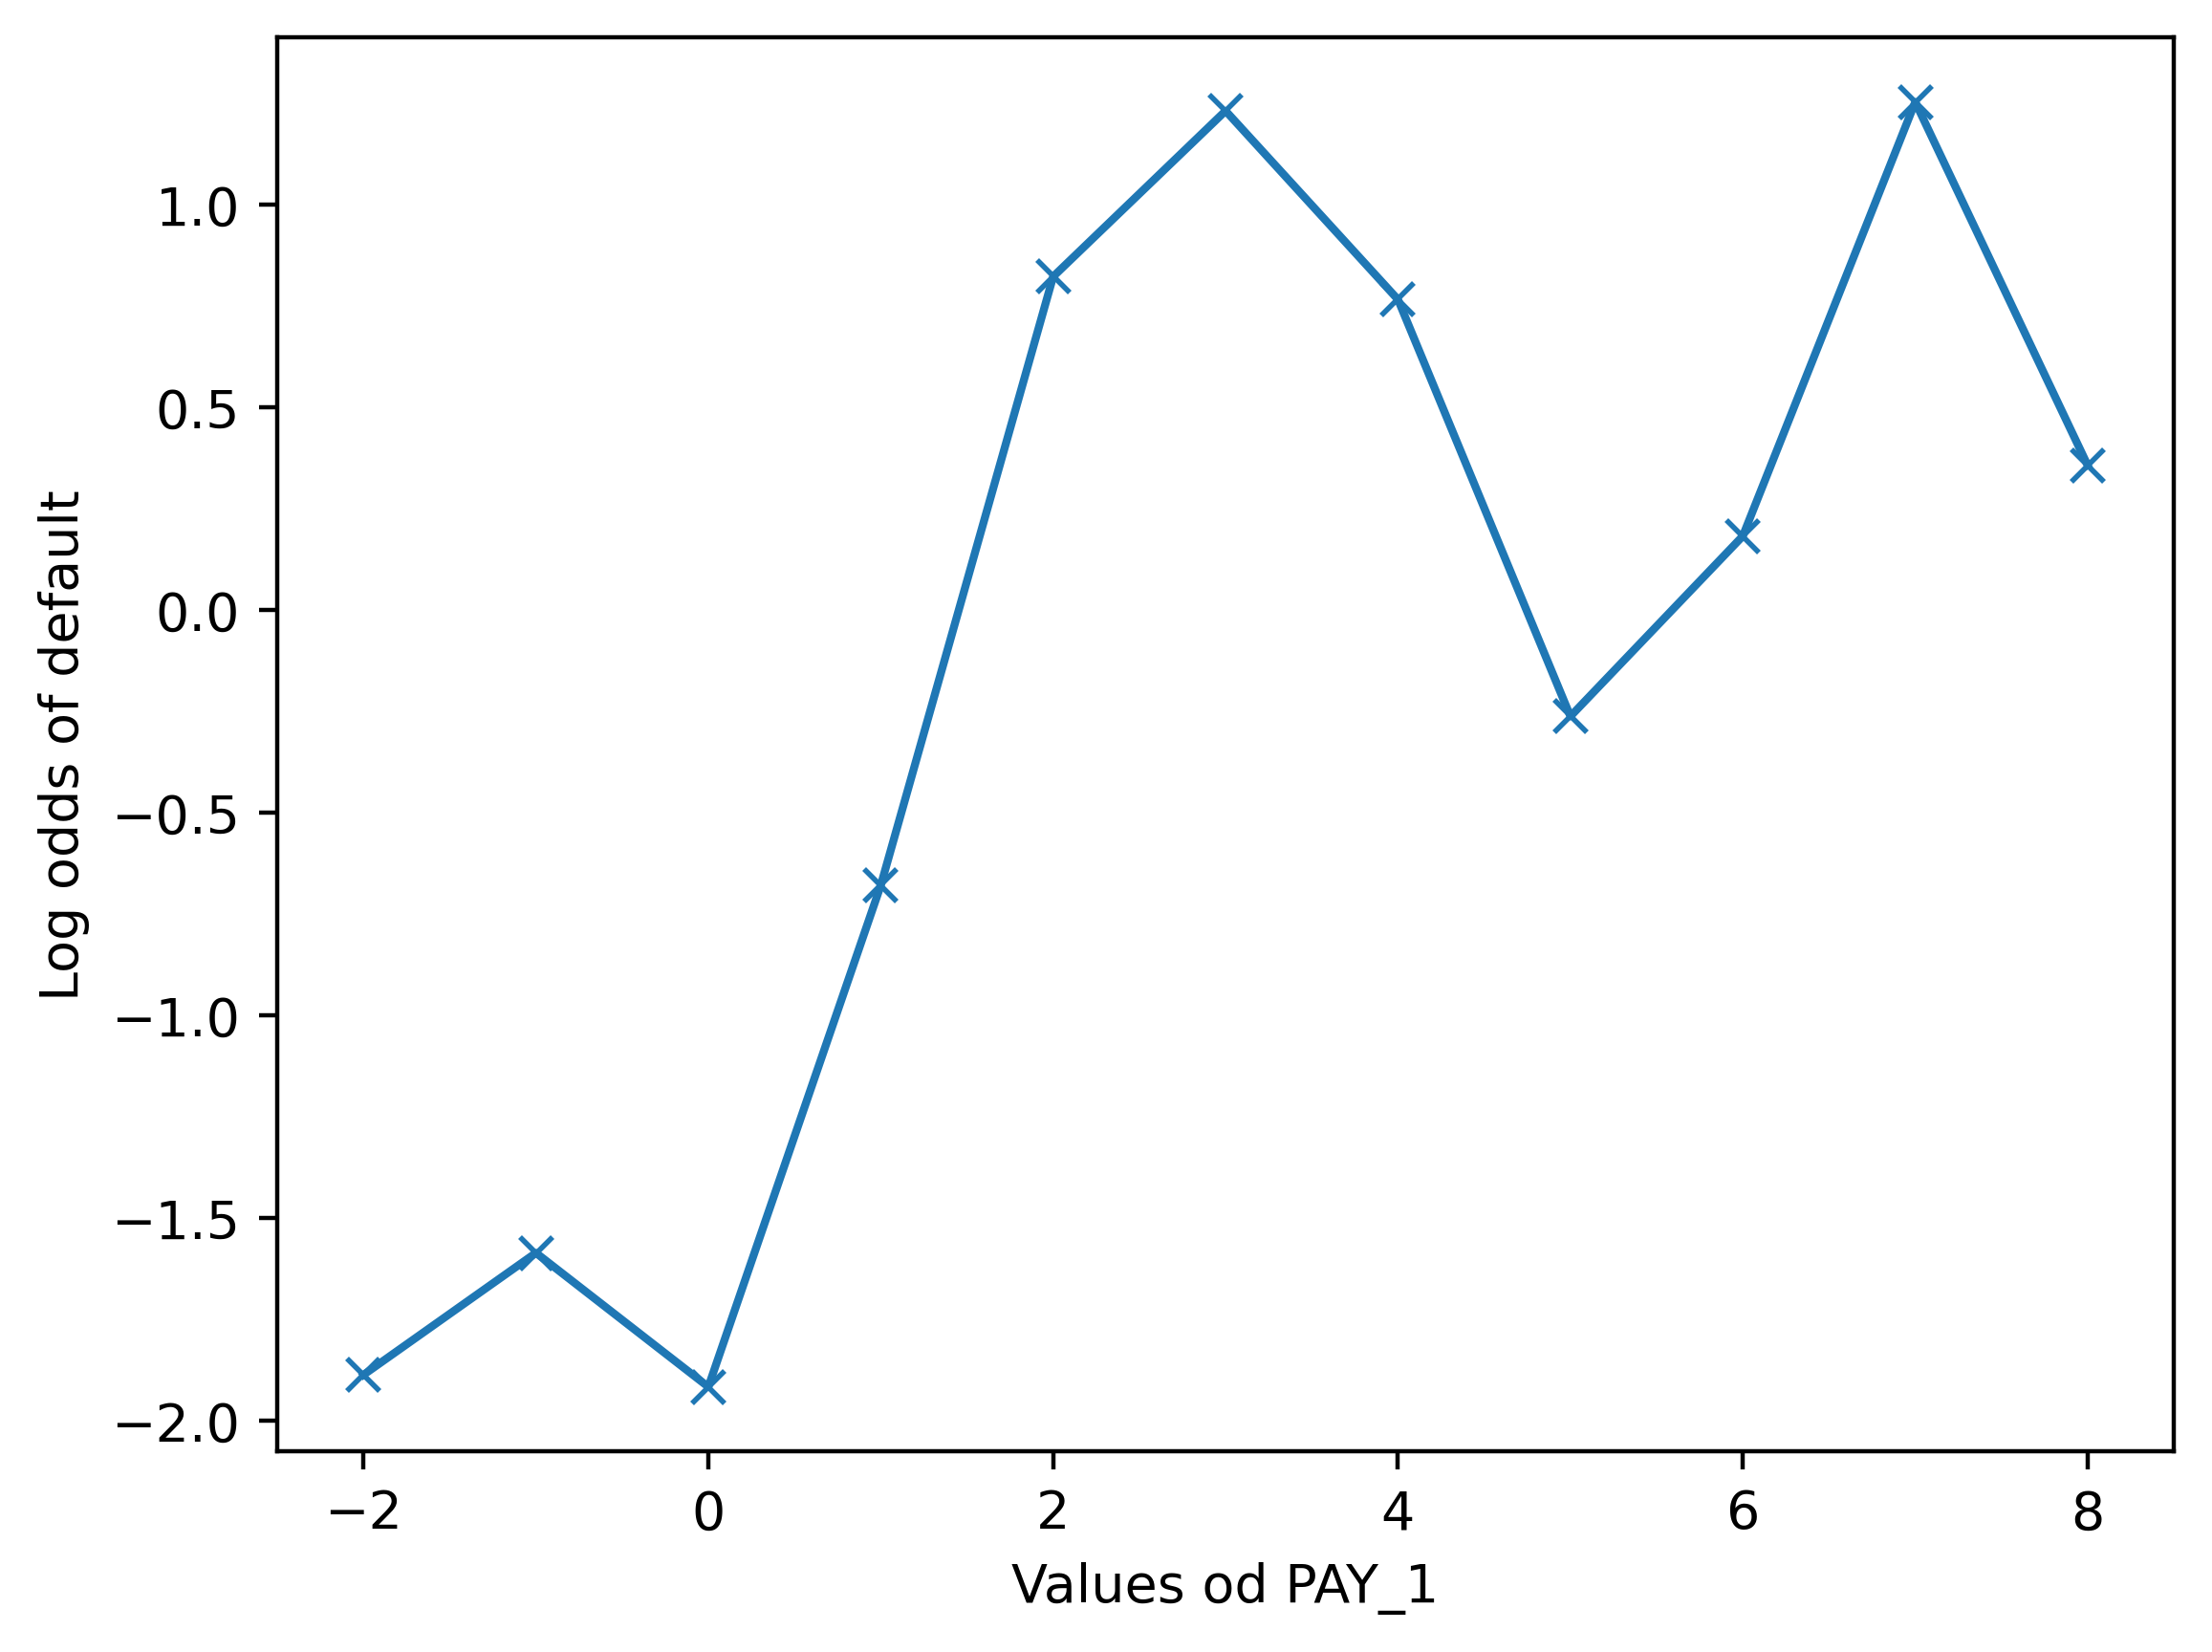

In [49]:
plt.plot(group_by_pay_mean_y.index, log_odds, '-x')
plt.ylabel('Log odds of default')
plt.xlabel('Values od PAY_1')

Podemos ver nessa plotagem que o relacionamento entre o logaritmo das chances da variável de resposta e a característica PAY_1 não é tão diferente do relacionamento entre a taxa de inadimplência e essa característica, plotado no exercício 12.

#### O ajuste de linha reta é um bom modelo para esses dados?

Parece que uma "linha de melhor ajuste" desenhada nessa plotagem subiria da esquerda para a direita. Ao mesmo tempo, os dados não dão a impressão de que resultariam de um processo realmente linear. Uma maneira de olharmos os dados seria considerar que os valores '-2, -1 e 0' parecem se enquadar em um regime de logaritmo das chances diferentes dos outros. PAY_1 = 1 é intermediário e o resto é em grande parte mais alto. Talvez uma engenharia de características baseada nessa variável, ou diferentes maneiras de codificar as categorias representadas por '-2, -1 e 0' seriam mais eficazes para a modelagem. Lembre-se disso enquanto continuamos a modelar os dados com uma regressão logística e depois usando outras abordagens.

#### Dos coeficientes da regressão logística às previsões com o uso da função sigmóide

Examinaremos como os coeficientes de uma regressão logística são usados para calcular probabilidades previstas e depois faremos previsões para a classe da variável de resposta.

-> Quando chamamos o método '.fit' em um objeto de modelo de regressão logística no scikit-learn usando os dados de treinamento, os parâmetros (a intersecção e os coeficientes), são estimados a partir dos dados de treinamento rótulados. Na verdade, o scikit-learn descobre como selecionar valores de modo a classificar corretamente o maior número de pontos de dados de treinamento. 

-> Quando chamamos o método '.predict', o scikit-learn calcula as probabilidades previstas de acordo com os valores de parâmetros ajustados e a equação sigmóide. Uma amostra específica será então classificada como positiva se 'p >= 0.5'; caso contrário será negativa.


##### Exercício 15 - Limite de decisão linear da regressão logística

Nesse exercício, ilustraremos o conceito de 'limite de decisão' para uma classificação binária. Usaremos dados sintéticos para criar um exemplo claro de visualização do limite de decisão da regressão logística em relação às amostras de treinamento.

Começaremos gerando aleatoriamente duas características, X1 e X2. Já que há duas características, podemos dizer que os dados desse problema são bidimensionais. Isso facilita a visualização. os conceitos que ilustraremos aqui podem ser generealizados para casos de mais de duas características, como os datasets do mundo real que provavelmente verá em seu trabalho; no entanto, o limite de decisão é mais difícil de visualizar em espaços com mais dimensões:

1) Gere as características usando o código a seguir:

In [50]:
np.random.seed(seed=6)
X_1_pos = np.random.uniform(low=1, high=7, size=(20, 1))
print(X_1_pos[0:30])
X_1_neg = np.random.uniform(low=3, high=10, size=(20, 1))
print(X_1_neg[0:3])
X_2_pos = np.random.uniform(low=1, high=7, size=(20, 1))
print(X_2_pos[0:3])
X_2_neg = np.random.uniform(low=3, high=10, size=(20, 1))

[[6.35716091]
 [2.99187883]
 [5.92737474]
 [1.25017975]
 [1.64594008]
 [4.57031239]
 [4.17890417]
 [3.51284457]
 [3.0124471 ]
 [4.73511659]
 [3.62884856]
 [5.41529264]
 [4.10821847]
 [4.4731516 ]
 [4.87213058]
 [6.94134563]
 [5.91914918]
 [3.47920561]
 [6.25760593]
 [5.9425566 ]]
[[3.38132155]
 [8.03046066]
 [8.61519394]]
[[5.4790643 ]
 [5.3444234 ]
 [3.43664678]]


2) Plote esses dados, colorindo as amostras positivas com vermelho e as negativas com azul. o código da plotagem é:

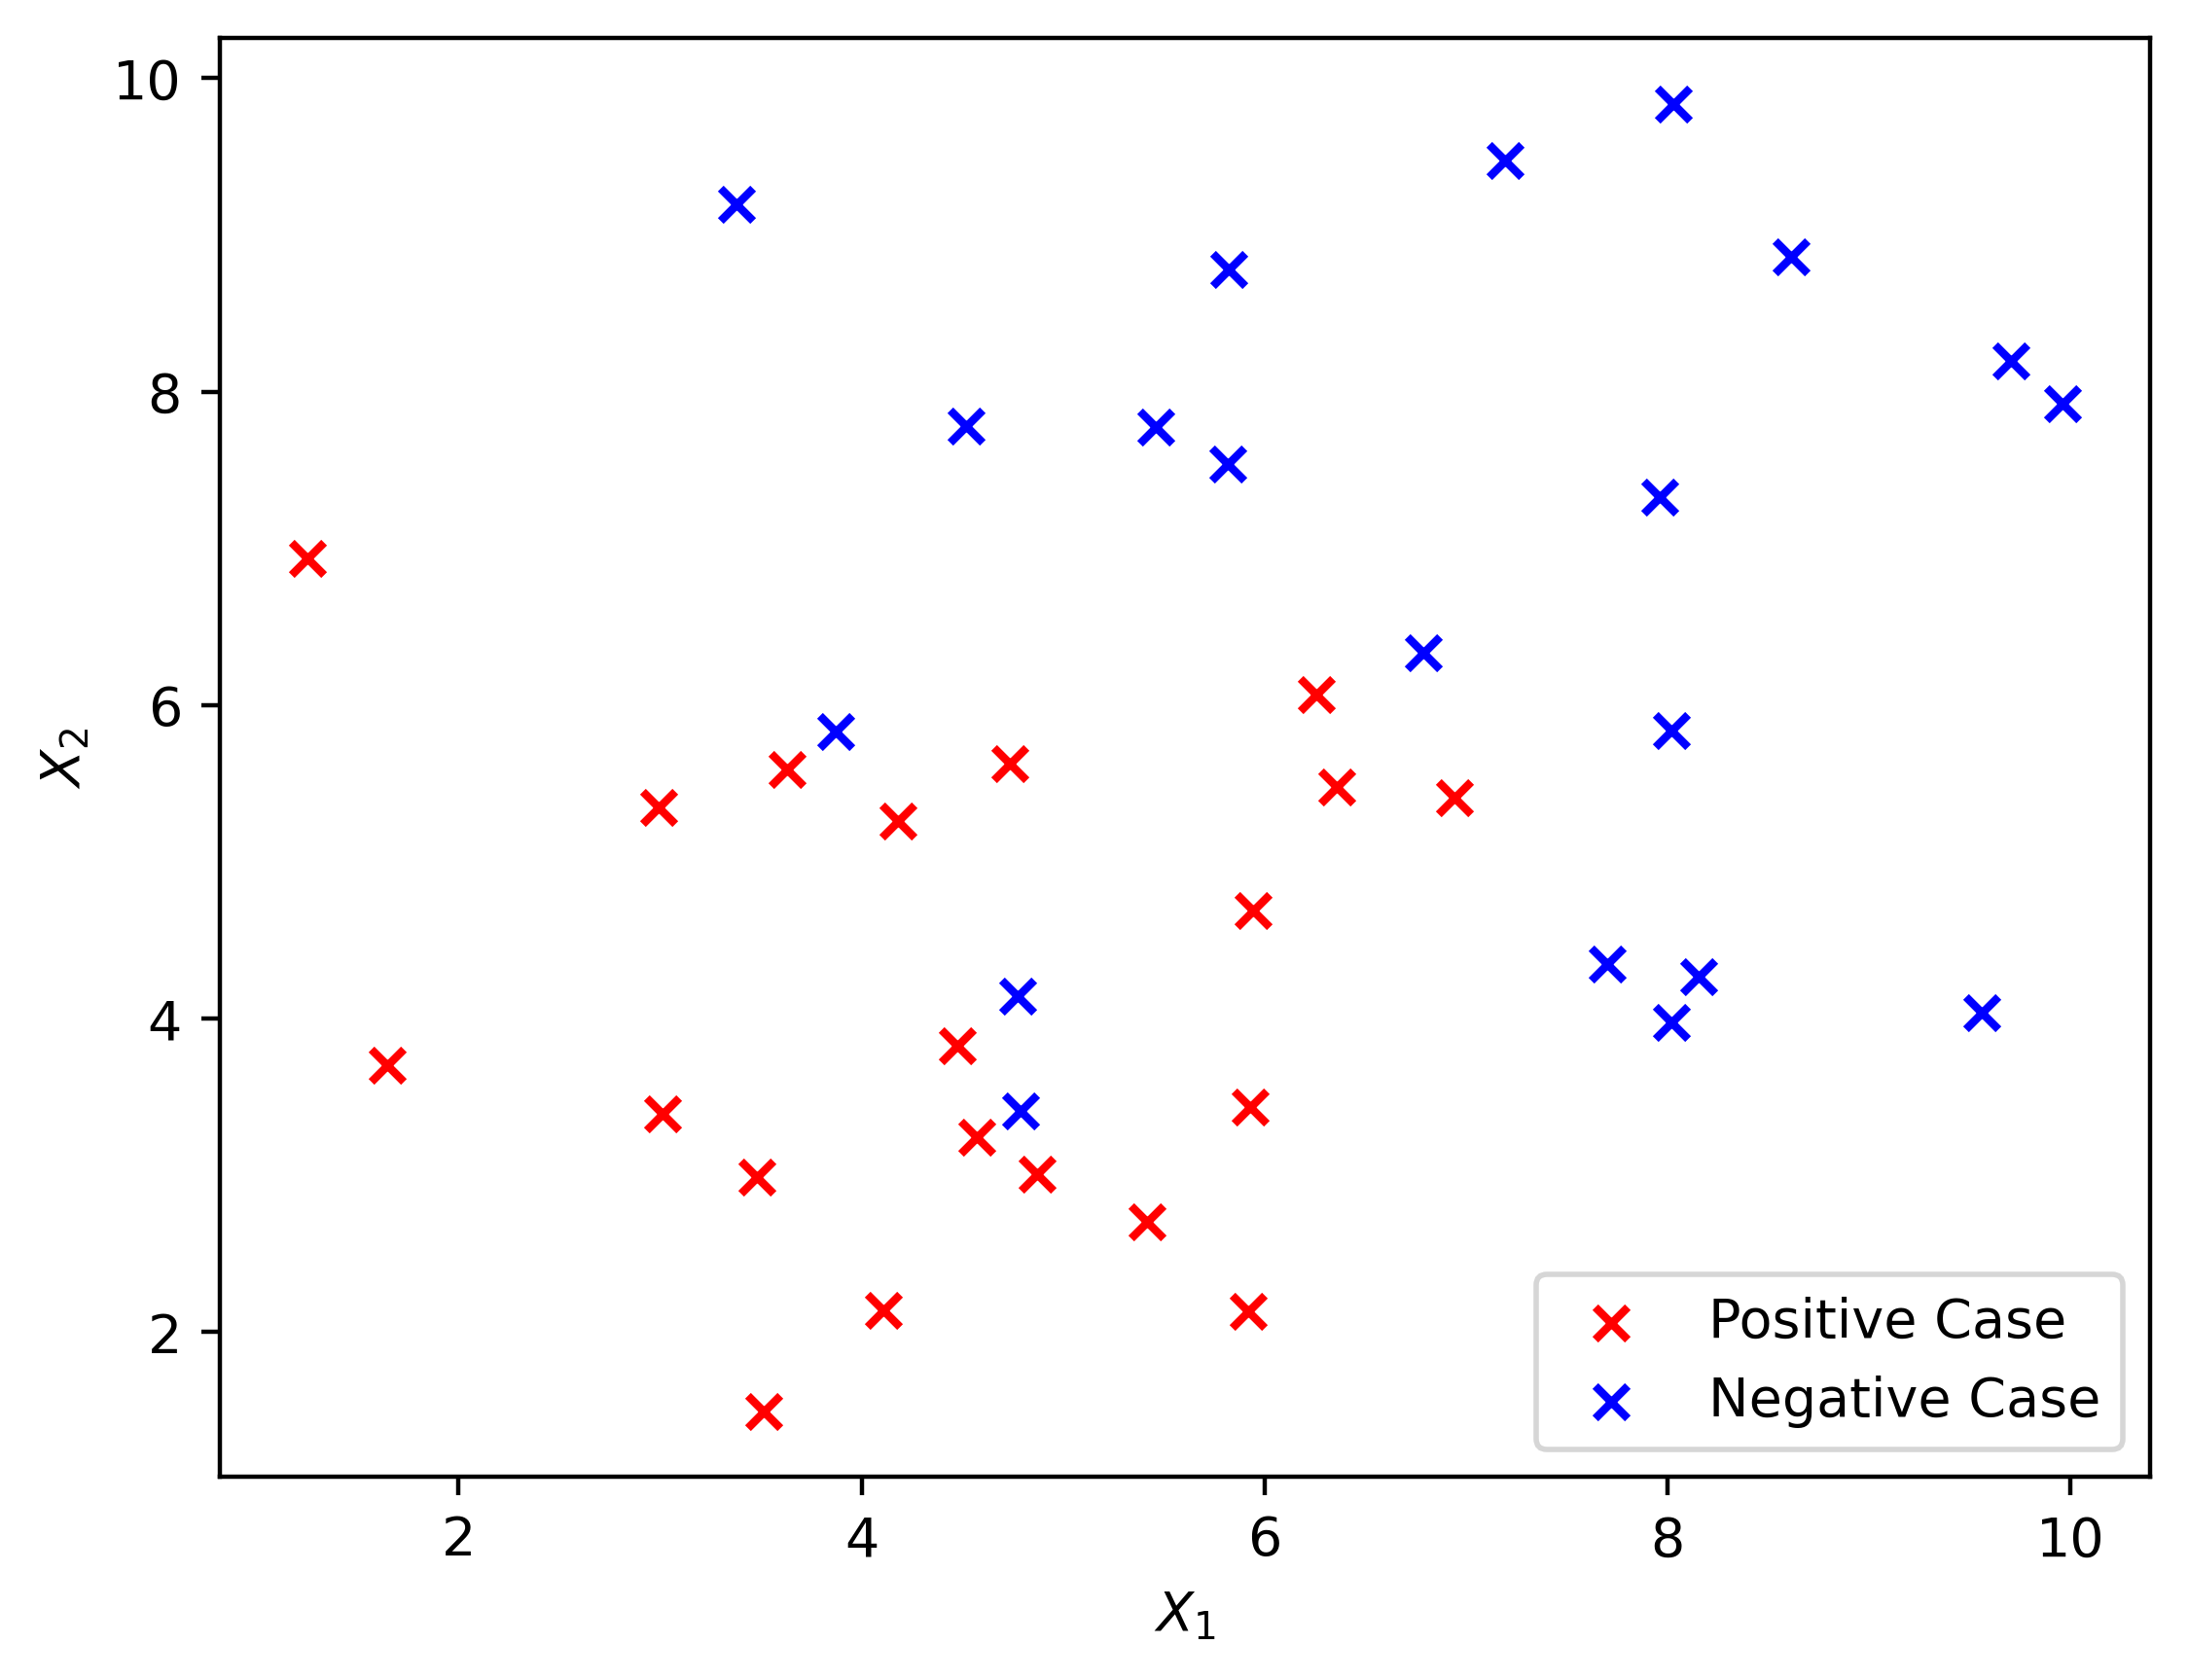

In [51]:
plt.scatter(X_1_pos, X_2_pos, color='red', marker='x')
plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(['Positive Case', 'Negative Case'])

Para usar nossas características sintéticas com o scikit-learn, temos de reuni-las em uma matriz. Usaremos a função block do NumPy para fazer isso e criar uma matriz de 40 por 2. Haverá 40 linhas porque há um total de 40 amostras e teremos 2 colunas porque há 2 características. Organizaremos as coisas de modo que as características das amostras positivas estejam nas 20 primeiras linhas e as das amostras negativas venham depois.

3) Crie uma matriz 40 por 2 e exiba a dimensão e as 3 primeiras linhas:

In [52]:
X = np.block([[X_1_pos, X_2_pos], [X_1_neg, X_2_neg]])
print(X.shape)
print(X[0:3])

(40, 2)
[[6.35716091 5.4790643 ]
 [2.99187883 5.3444234 ]
 [5.92737474 3.43664678]]


Também precisamos de uma variável de resposta para acompanhar as características. Sabemos como defini-las, mas precisamos de um array de valores y para informar ao scikit-learn.

4) Crie uma pilha vertical (vstack) de 20 1's e 20 0's que corresponda à organização das características e redimensione-a para a maneira que o scikit-learn espera. Aqui está o código:

In [53]:
y = np.vstack((np.ones((20,1)), np.zeros((20, 1)))).reshape(40,)
print(y[0:5])
print(y[-5:])

[1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0.]


Estamos prontos para ajustar o modelo de regressão logística para esses dados com scikit-learn. Usaremos todos os dados como dados de treinamento e examinaremos com que eficácia um modelo linear conseguirá ajustá-los. As próximas etapas devem ser familiares devido ao trabalho em capítulos anteriores sobre como instanciar uma classe de modelo e como ajustar o modelo.

5) Primeiro, importe a classe de modelo usando o código a seguir:

In [54]:
from sklearn.linear_model import LogisticRegression

6) Agora instancie, indicando o solver liblinear, e exiba o objeto de modelo usando este código:

In [55]:
example_lr = LogisticRegression(solver='liblinear')
example_lr

LogisticRegression(solver='liblinear')

7) Treine o modelo com os dados sintéticos:

In [56]:
example_lr.fit(X, y)

LogisticRegression(solver='liblinear')

Como ficarão as previsões de nosso modelo ajustado?

Primeiro temos de obter as previsões usando o método '.predict' do modelo treinado, com as mesmas amostras empregadas no treinamento. Em seguida, para adiconar as previsões à plotagem usando o esquema de cores vermelha = classe positiva e azul = classe negativa, criaremos duas listas de índices para utilizar com os arrays, dependendo de se as previsões forem 1 ou 0. Utilizar o list compregension incluindo uma instrução if para fazê-lo.

8) Use esse código para obter as previsões e separe-as em índices de previsões de classe positiva e negativa. Exiba os índices de previsões de classe positiva como uma verificação:

In [57]:
y_pred = example_lr.predict(X)
positive_indices = [counter for counter in range(len(y_pred)) if y_pred[counter] == 1]
negative_indices = [counter for counter in range(len(y_pred)) if y_pred[counter] == 0]
positive_indices

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 32, 38]

Pelos índices das previsões positivas já podemos dizer que algumas amostras dos dados de treinamento foram classificadas incorretamente: as amostras positivas são as 20 primeiras, mas aqui há índices foram desse intervalo. Deve ter percebido que um limite de decisão linear não conseguiria classificar corretamente esses dados. Agora inseriremos as previsões na plotagem, na forma de círculos ao redor de cada ponto de dados e usando cores de acordo com a previsão. Pode comparar a cor dos símbolos X, os rótulos reais dos dados, com a cor dos círculos (previsões), para ver que pontos foram classificados corretamente e incorretamente.

9) Aqui está o código da plotagem

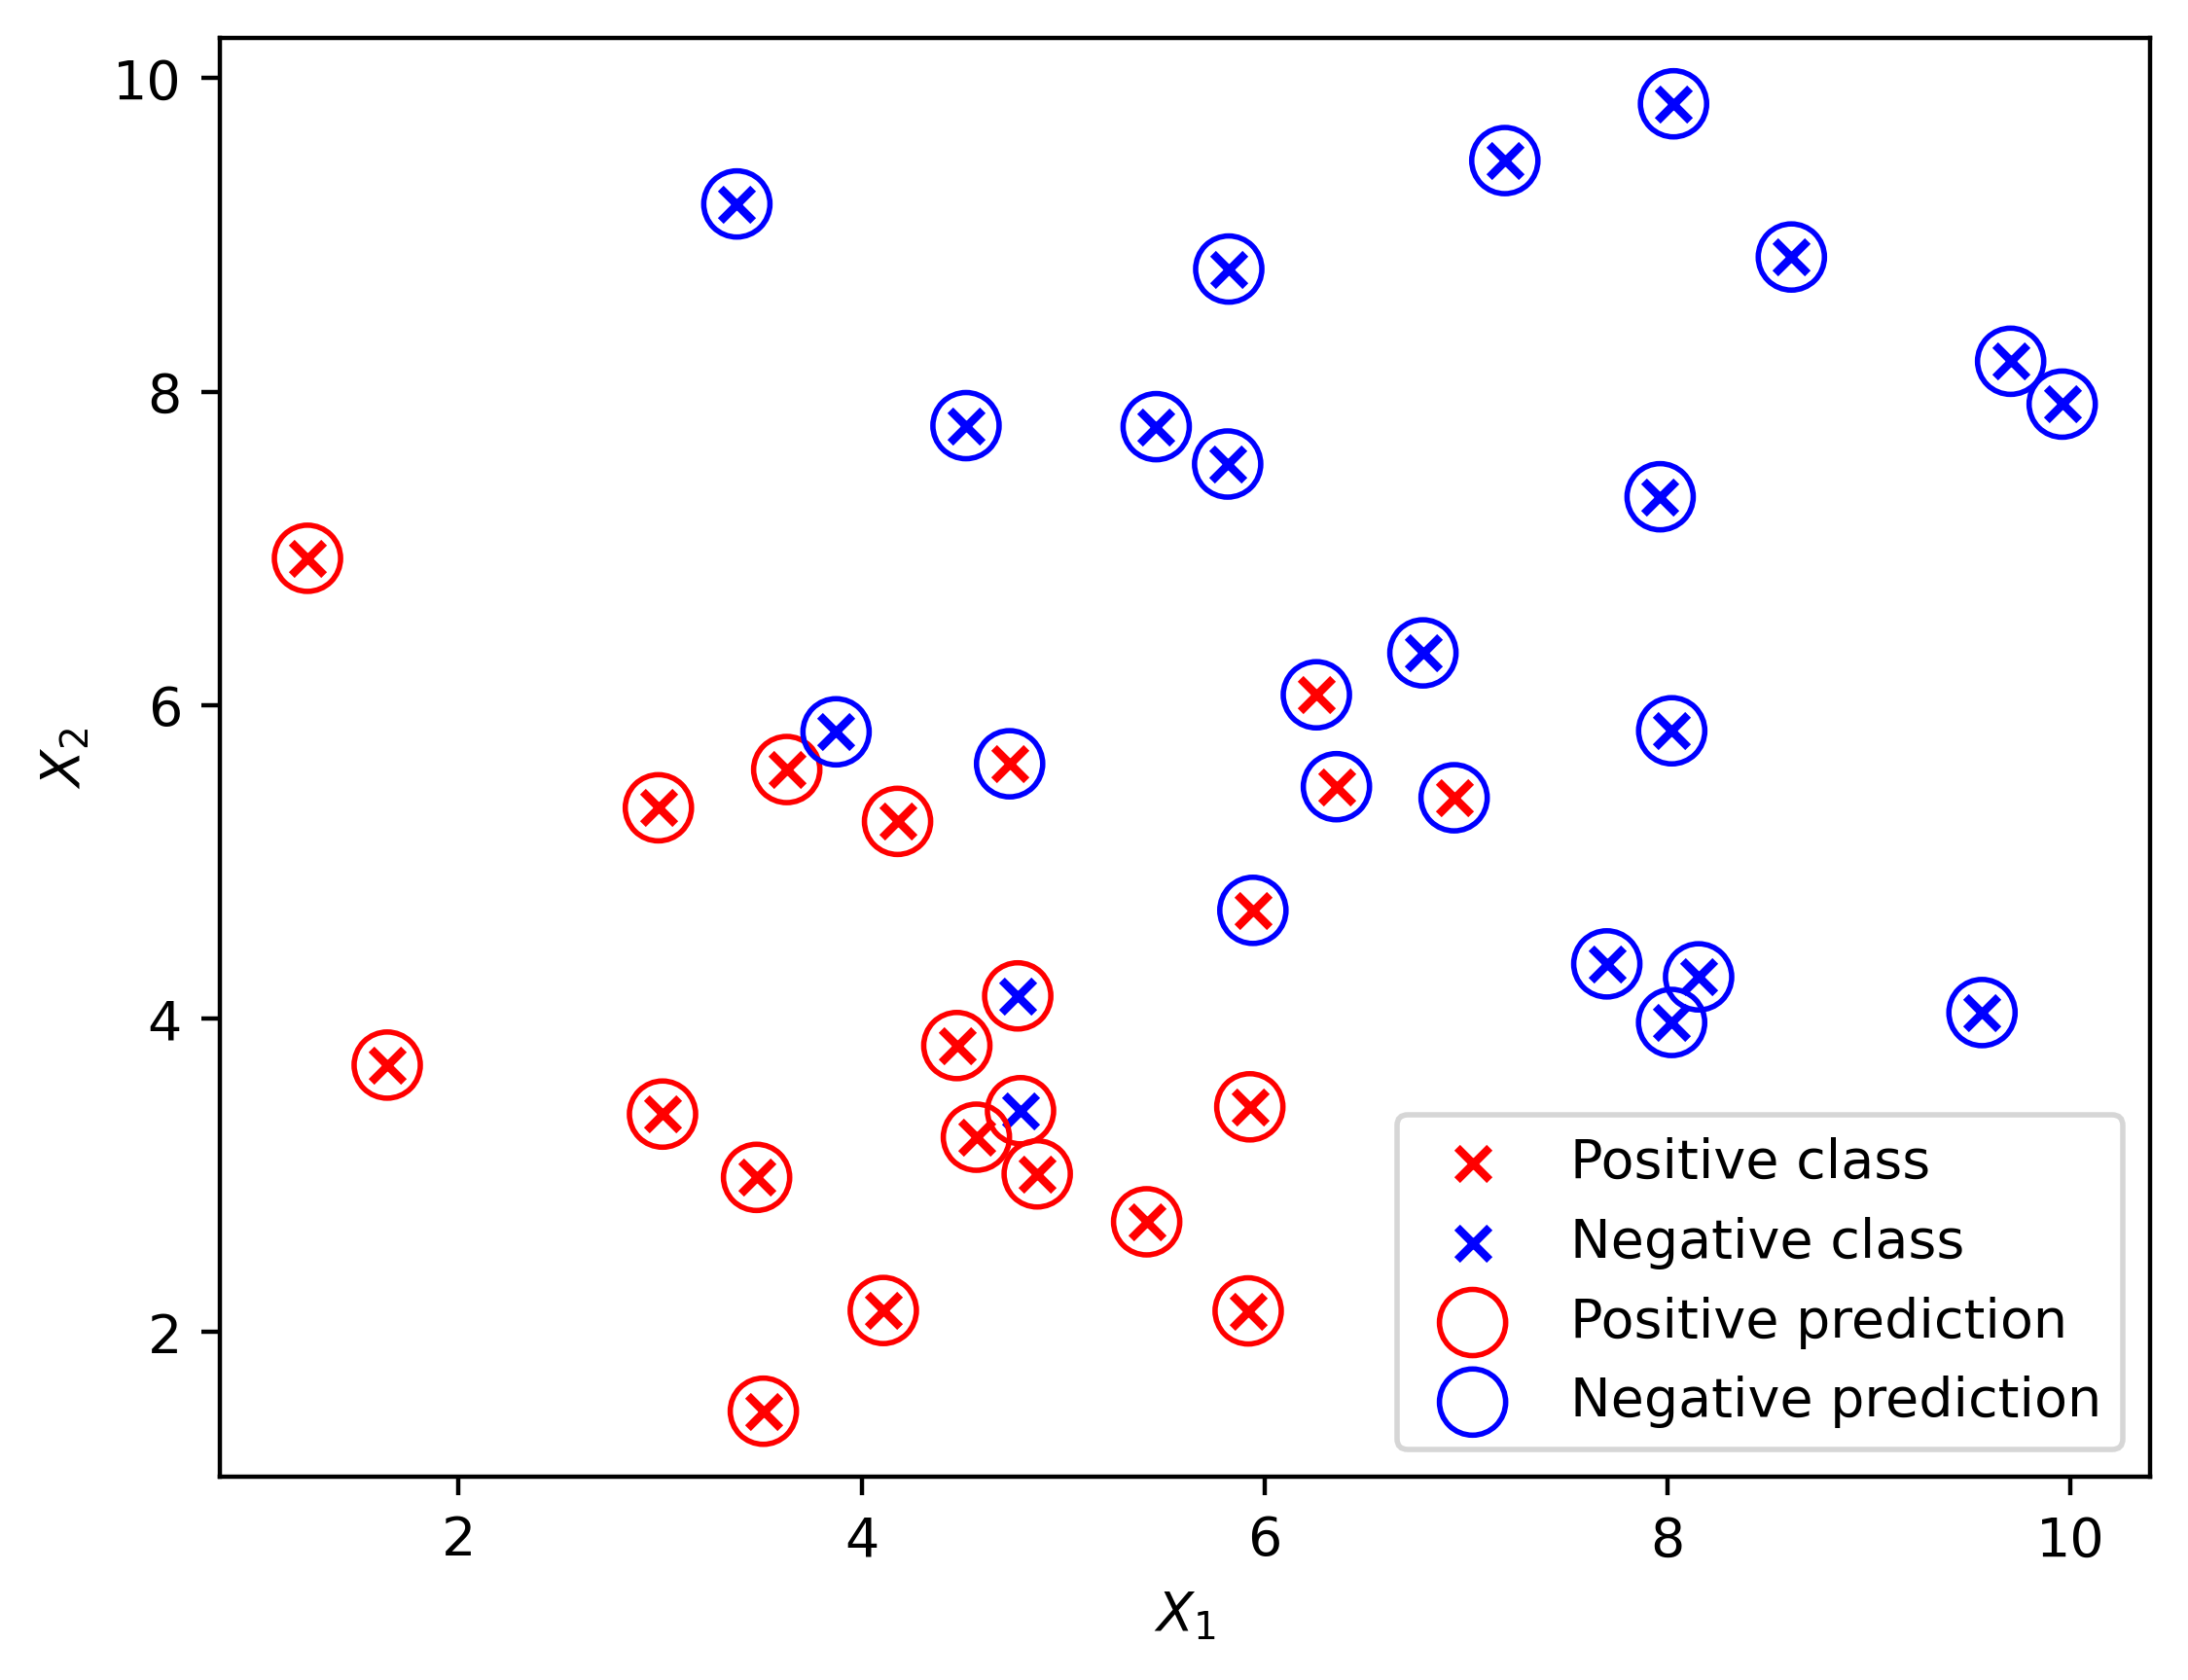

In [58]:
plt.scatter(X_1_pos, X_2_pos, color='red', marker='x')
plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x')
plt.scatter(X[positive_indices, 0], X[positive_indices, 1], s=150, marker='o', 
            edgecolor='red', facecolor='none')
plt.scatter(X[negative_indices, 0], X[negative_indices, 1], s=150, marker='o', 
           edgecolor='blue', facecolor='none')

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(['Positive class', 'Negative class', 'Positive prediction', 'Negative prediction'])

Pela plotagem, fica claro que o classificador tem problemas com os pontos de dados que estão perto de onde seria o limite de decisão linear; alguns deles podem acabar no lado errado desse limite. Como poderíamos definir, e visualizar, a localização real do limite de decisão? De acordo com a seção anteriorm sabemos que podemos obter o limite de decisão de uma regressão logística, no espaço de características bidimensional.

10) Use este código para obter os coeficientes do modelo ajustado e exibi-los:

In [59]:
theta_1 = example_lr.coef_[0][0]
theta_2 = example_lr.coef_[0][1]
print(theta_1, theta_2)

-0.20245058016285838 -0.25336423626773225


11) use o código a seguir para obter a interceptação:

In [60]:
theta_0 = example_lr.intercept_

Agora use os coeficientes e a interceptação para definir o limite de decisão linear.

In [61]:
X_1_decision_boundary = np.array([0, 10])
X_2_decision_boundary = -(theta_1/theta_2)*X_1_decision_boundary - (theta_0/theta_2)

12) Plote o limite de decisão usando o código a seguir, com alguns ajustes para atribuir os rótulos corretos para a legenda e movê-la para um local (loc) fora da plotagem se estiver ficando abarrotada:

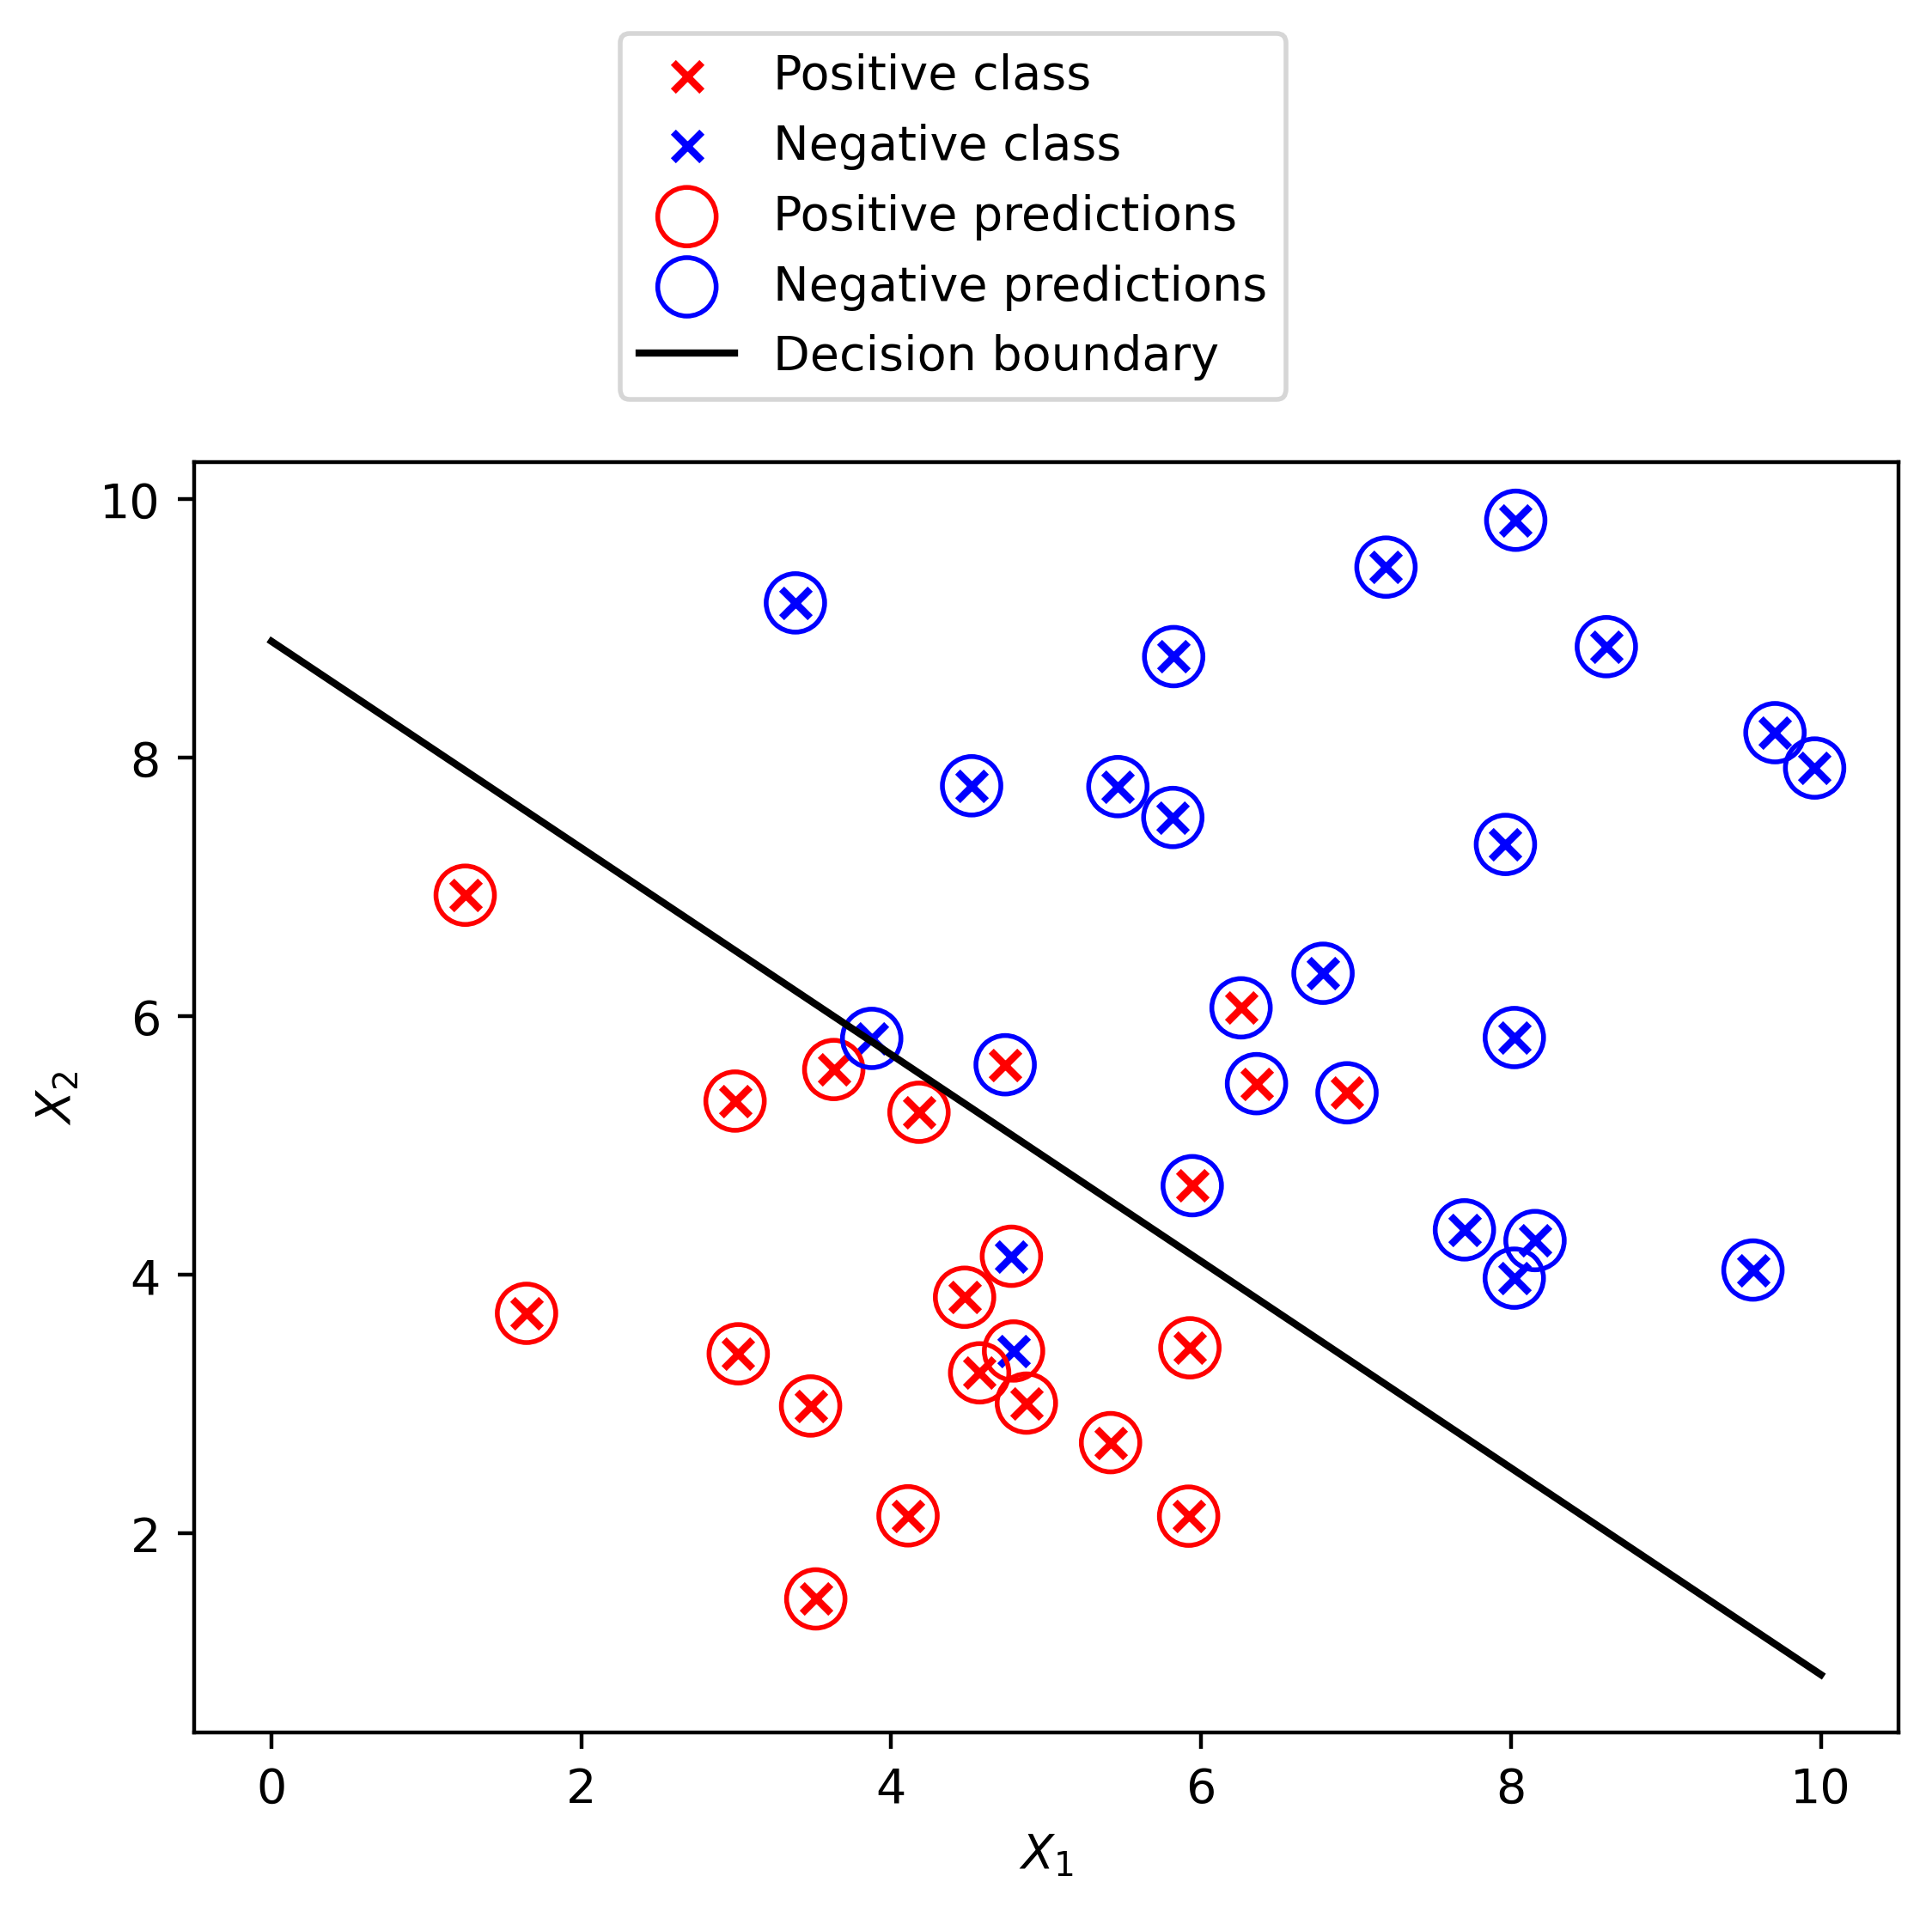

In [63]:
pos_true = plt.scatter(X_1_pos, X_2_pos, color='red', marker='x', 
                       label='Positive class')

neg_true = plt.scatter(X_1_neg, X_2_neg, color='blue', marker='x', 
                       label='Negative class')

pos_pred = plt.scatter(X[positive_indices, 0], X[positive_indices, 1], s=150, 
                       marker='o', edgecolor='red', facecolor='None', label='Positive predictions')

neg_pred = plt.scatter(X[negative_indices, 0], X[negative_indices, 1], s=150,
                       marker='o', edgecolor='blue', facecolor='None', label='Negative predictions')

dec = plt.plot(X_1_decision_boundary, X_2_decision_boundary, 'k-', label='Decision boundary')

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(loc=[0.25, 1.05])

###### Qual é a diferença no limite de decisão em comparação com onde achou que ele estaria?

###### Consegue perceber que um limite de decisão linear nunca classificaria com perfeição esses dados?

Como uma maneira de resolver esse problema, poderíamos criar 'características obtidas por engenharia' a partir de características existentes, como polinômios e interações, para permitir limites de decisão mais complexos e não lineares com a floresta aleatória, que também pode fazer isso.

Como observação final, esse exemplo foi visualizado facilmente em duas dimensões porque há apenas duas características. Em geral, o limite de decisão pode ser descrito por um hiperplano, que é a generalização de uma linha reta para espaços multidimensionais. No entanto, a natureza restritiva do limite de decisão linear também é um problema nos hiperplanos.

#### Resumo

Neste capítulo, aprendemos como explorar as características individualmente, usando métodos de seleção de características univariada, inclusive a correlação de Pearson e um teste F Anova. Embora examinar as características dessa forma nem sempre forneça um quadro geral, já que podemos estar perdendo interações importantes entre as características, trata-se de uma etapa necessária. Entender os relacionamentos entre as características mais preditivas e a variável de resposta, e criar visualizações eficazes a partir deles, é uma ótima maneira de comunicar as descobertas para o cliente. Também usamos plotagens personalizadas, como a sobreposição de histogramas criada pelo Matplotlib, para gear visualizações das características mais importantes.